In [ ]:
# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy import stats
from collections import OrderedDict

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA 
from statsmodels.sandbox.stats.multicomp import multipletests 

from __init__ import *
import snmcseq_utils
from snmcseq_utils import create_logger 
from snmcseq_utils import plot_tsne_values
from snmcseq_utils import plot_tsne_labels
from snmcseq_utils import tsne_and_boxplot
from CEMBA_update_mysql import connect_sql
from CEMBA_update_mysql import gene_id_to_table_name as id2table
from CEMBA_init_ensemble_v2 import pull_genebody_info

In [2]:
import importlib
importlib.reload(snmcseq_utils)

<module 'snmcseq_utils' from '/cndd/fangming/CEMBA/snmcseq_dev/snmcseq_utils.py'>

In [3]:
log = create_logger()
engine = connect_sql(DATABASE)

ens = 'Ens7'
context = 'CH'

ens_path = os.path.join(PATH_ENSEMBLES, ens)
ens_genelevel_path = os.path.join(ens_path, 'gene_level')

In [4]:
cell_types = ['mDL-1', 'mDL-2', 'mDL-3', 'mL2/3', 'mL4', 'mL5-1', 'mL5-2', 'mL5-3',
       'mL5-4', 'mL6-1', 'mL6-2', 'mL6-3', 'mNdnf-1', 'mNdnf-2', 'mPv',
       'mSst-1', 'mSst-2', 'mSst-3', 'mVip', 'unlabeled']

cell_classes = ['Ex']*12 + ['In']*7 + ['Glia'] 
df_cell_class = pd.DataFrame()
df_cell_class['cell_type'] = cell_types
df_cell_class['cell_class'] = cell_classes
df_cell_class = df_cell_class.set_index('cell_type')
df_cell_class.head()

cell_class
cell_type           
mDL-1             Ex
mDL-2             Ex
mDL-3             Ex
mL2/3             Ex
mL4               Ex

In [5]:
tsne_cols = ['tsne_x_mCHmCG_ndim2_perp30', 'tsne_y_mCHmCG_ndim2_perp30']
cluster_col = 'cluster_mCHmCG_lv_npc50_k30'
annot_col = 'annotation_mCHmCG_lv_npc50_k30'

sql = 'SELECT * FROM cells JOIN {} ON cells.cell_id = {}.cell_id'.format(ens, ens)
df_info = pd.read_sql(sql, engine, index_col='cell_name')
# mark none as unlabeled
df_info[annot_col] = [annot if annot else 'unlabeled' for annot in df_info[annot_col]]
df_info = pd.merge(df_info, df_cell_class, left_on=annot_col, right_index=True)
df_info = df_info[df_info['dataset'].isin(['CEMBA_3C_171207', 'CEMBA_4B_171213'])]
print(df_info.shape)
df_info.head()

sql = 'SELECT * FROM genes'
df_gene = pd.read_sql(sql, engine, index_col='gene_id')
# back compatible
df_gene['geneName'] = df_gene['gene_name']
df_gene.head()

(2531, 140)


gene_name    chr      start        end strand  \
gene_id                                                               
ENSMUSG00000000001.4      Gnai3   chr3  108107280  108146146      -   
ENSMUSG00000000003.15      Pbsn   chrX   77837901   77853623      -   
ENSMUSG00000000028.14     Cdc45  chr16   18780447   18811987      -   
ENSMUSG00000000031.16       H19   chr7  142575529  142578143      -   
ENSMUSG00000000037.16     Scml2   chrX  161117193  161258213      +   

                            gene_type geneName  
gene_id                                         
ENSMUSG00000000001.4   protein_coding    Gnai3  
ENSMUSG00000000003.15  protein_coding     Pbsn  
ENSMUSG00000000028.14  protein_coding    Cdc45  
ENSMUSG00000000031.16         lincRNA      H19  
ENSMUSG00000000037.16  protein_coding    Scml2

In [6]:
df_info['region'] = [dataset.split('_')[1] for dataset in df_info['dataset']]

# back-compatible
df_info['Biosample'] = df_info['region'].values
df_info['cluster_ID'] = df_info[cluster_col].values
df_info['cluster_annotation'] = df_info[annot_col].values
df_info['mCH/CH'] = df_info['global_mCH'].values


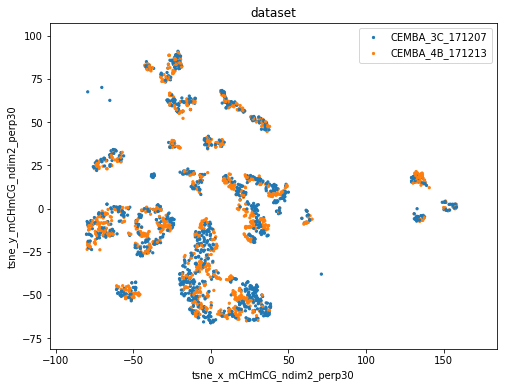

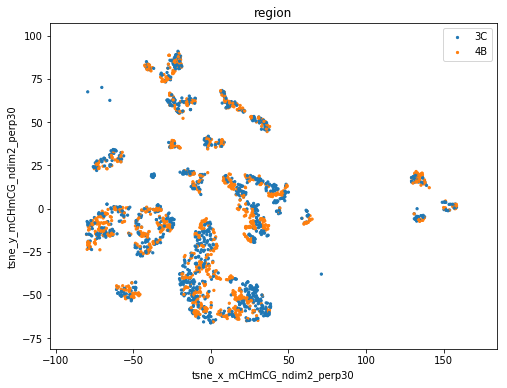

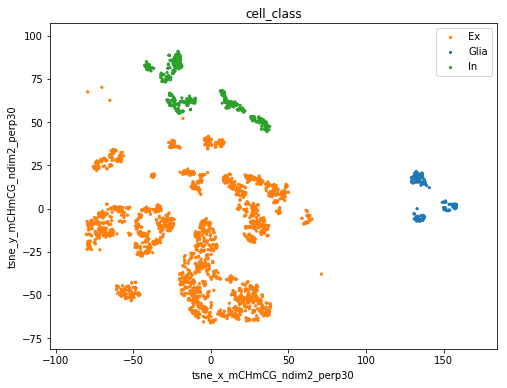

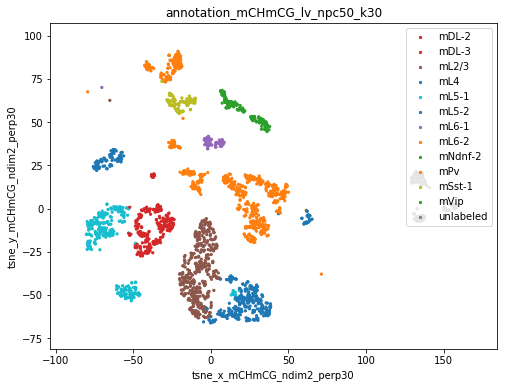

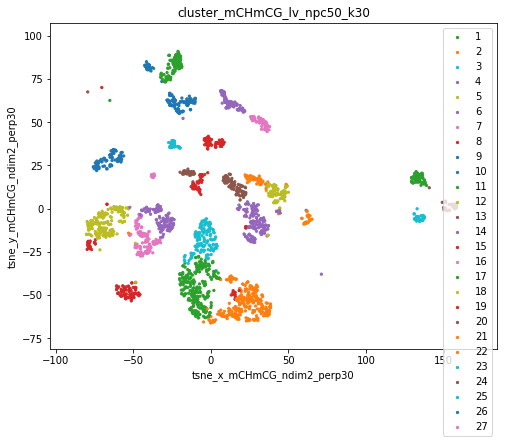

In [7]:
# plot tsne by clustering by datasat
plot_tsne_labels(df_info, tx=tsne_cols[0], ty=tsne_cols[1], tc='dataset', s=5)
plot_tsne_labels(df_info, tx=tsne_cols[0], ty=tsne_cols[1], tc='region', s=5)
plot_tsne_labels(df_info, tx=tsne_cols[0], ty=tsne_cols[1], tc='cell_class', s=5)
plot_tsne_labels(df_info, tx=tsne_cols[0], ty=tsne_cols[1], tc=annot_col, s=5)
plot_tsne_labels(df_info, tx=tsne_cols[0], ty=tsne_cols[1], tc=cluster_col, s=5)

In [8]:
# df_info['genebody_path'] = ['{}/{}/gene_level/genebody_{}.tsv.bgz'.format(PATH_DATASETS, dataset, cell_name) 
#                             for dataset, cell_name in zip(df_info.dataset, df_info.index)]
# pull_genebody_info(ens, ens_genelevel_path, df_info.index.tolist(), df_info['genebody_path'].tolist(), to_file=True)

In [9]:
mc_c_file = os.path.join(ens_path, 'gene_level/genebody_m{}_{}.tsv.bgz'.format(context, ens))
df = snmcseq_utils.read_genebody(mc_c_file, compression='gzip')
print(df.shape)
df.head()

(51772, 8058)


171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_A11_AD002_indexed_mc  \
gene_id                                                                                                       
ENSMUSG00000102693.1                                                  0                                       
ENSMUSG00000064842.1                                                  0                                       
ENSMUSG00000051951.5                                                  4                                       
ENSMUSG00000102851.1                                                  0                                       
ENSMUSG00000103377.1                                                  0                                       

                      171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_A11_AD002_indexed_c  \
gene_id                                                                                                      
ENSMUSG00000102693.1                                                  0                                      
ENSMUSG00000064842.1                                                  0                                      
ENSMUSG00000051951.5                                                 68                                      
ENSMUSG00000102851.1                                                  0                                      
ENSMUSG00000103377.1                                                  0                                      

                      171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A3_AD001_indexed_mc  \
gene_id                                                                                                      
ENSMUSG00000102693.1                                                  0                                      
ENSMUSG00000064842.1                                                  0                                      
ENSMUSG00000051951.5                                                101                                      
ENSMUSG00000102851.1                                                  2                                      
ENSMUSG00000103377.1                                                  1                                      

                      171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A3_AD001_indexed_c  \
gene_id                                                                                                     
ENSMUSG00000102693.1                                                  0                                     
ENSMUSG00000064842.1                                                  0                                     
ENSMUSG00000051951.5                                               8065                                     
ENSMUSG00000102851.1                                                 43                                     
ENSMUSG00000103377.1                                                 86                                     

                      171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_G3_AD004_indexed_mc  \
gene_id                                                                                                      
ENSMUSG00000102693.1                                                  0                                      
ENSMUSG00000064842.1                                                  0                                      
ENSMUSG00000051951.5                                                 92                                      
ENSMUSG00000102851.1                                                  0                                      
ENSMUSG00000103377.1                                                  0                                      

                      171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_G3_AD004_indexed_c  \
gene_id                                                   

In [10]:
# get only cells from df_info 
cells = df_info.index.values 
df = df[np.concatenate((cells+'_mc', cells+'_c'))]
df_mc = df.filter(regex='_mc')
df_c = df.filter(regex='_c')

df_mc.columns = [col[:-len('_mc')] for col in df_mc.columns]
df_c.columns = [col[:-len('_c')] for col in df_c.columns]

print(df_mc.shape)
print(df_c.shape)


(51772, 2531)
(51772, 2531)


In [11]:
# remove low coverage gene

base_call_cutoff = 100 
sufficient_coverage_fraction = 0.94 
condition = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*(df.shape[1])/2.0 


print("Matrix size before pruning... "+ str(df.shape))
df_f = df.loc[condition]
print("Matrix size after pruning... "+ str(df_f.shape))

# get mcc matrix with kept bins and nan values for low coverage sites
df_c_nan = df_c.copy()
df_c_nan[df_c < base_call_cutoff] = np.nan
df_mcc = df_mc.loc[condition]/df_c_nan.loc[condition]
print(df_mcc.shape)

# imputation (missing value -> mean value of all cells)
print('Imputing data...')
means = df_mcc.mean(axis=1)
fill_value = pd.DataFrame({col: means for col in df_mcc.columns})
df_mcc.fillna(fill_value, inplace=True)

# add "_mcc" suffix
df_mcc.columns = df_mcc.columns.values + '_mcc'


Matrix size before pruning... (51772, 5062)
Matrix size after pruning... (10416, 5062)
(10416, 2531)
Imputing data...


# End of preprocessing

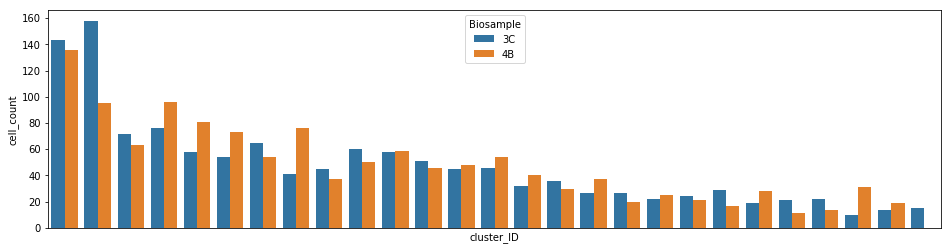

In [12]:
"""
For every cluster, plot biosample related quantities
"""
# cell_count1 = df_info[df_info.Biosample=='MB_v1'].shape[0]
# cell_count2 = df_info[df_info.Biosample=='MB_EA'].shape[0]
# cell_count3 = df_info[df_info.Biosample=='MB_EB'].shape[0]
# print(cell_count1)
# print(cell_count2)
# print(cell_count3)

df_counts = df_info.groupby(['cluster_ID', 'Biosample']).count()['mCH/CH'].to_frame()
df_counts.reset_index(level=['cluster_ID', 'Biosample'], inplace=True)
df_counts.columns = ['cluster_ID', 'Biosample', 'cell_count']

fig, ax = plt.subplots(figsize=(16, 4))
ax = sns.barplot(x="cluster_ID", y="cell_count", hue="Biosample", data=df_counts)
ax.set_xticks([])
plt.show()

In [13]:
df_sample_counts = df_info.groupby('Biosample').count()['mCH/CH'].to_frame()
df_sample_counts.columns = ['tc_biosample']
df_counts_new = pd.merge(df_counts, df_sample_counts, left_on='Biosample', right_index=True)
df_counts_new['cell_ratio'] = df_counts_new.cell_count/df_counts_new.tc_biosample


df_cluster_counts = df_info.groupby('cluster_ID').count()['mCH/CH'].to_frame()
df_cluster_counts.columns = ['tc_cluster']
df_counts_new = pd.merge(df_counts_new, df_cluster_counts, left_on='cluster_ID', right_index=True)
df_counts_new['cell_ratio_cluster'] = df_counts_new.cell_ratio/df_counts_new.tc_cluster

print(df_counts_new.shape)
df_counts_new.head()

(53, 7)


cluster_ID Biosample  cell_count  tc_biosample  cell_ratio  tc_cluster  \
0           1        3C         143          1270    0.112598         279   
1           1        4B         136          1261    0.107851         279   
2           2        3C         158          1270    0.124409         253   
3           2        4B          95          1261    0.075337         253   
4           3        3C          72          1270    0.056693         135   

   cell_ratio_cluster  
0            0.000404  
1            0.000387  
2            0.000492  
3            0.000298  
4            0.000420

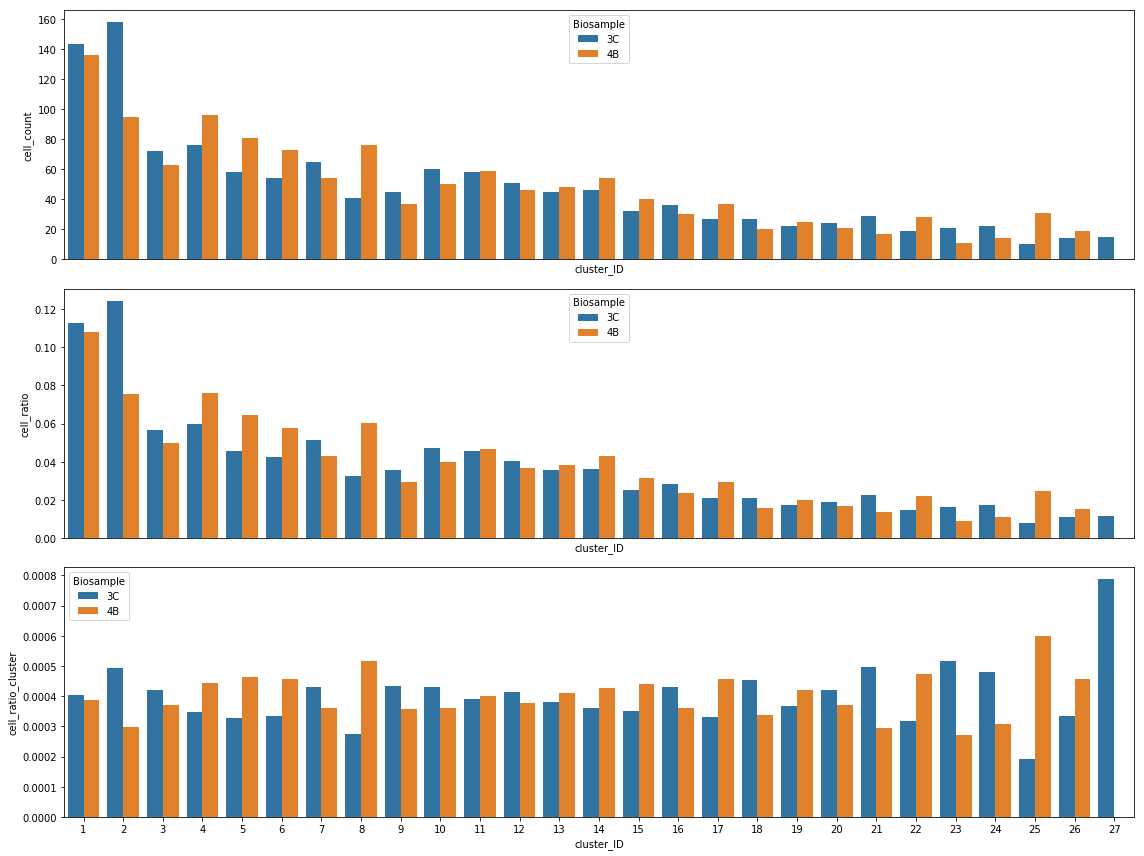

In [14]:
fig, axs = plt.subplots(3, 1, figsize=(16, 12))
ax = axs[0]
sns.barplot(x="cluster_ID", y="cell_count", hue="Biosample", data=df_counts_new, ax=ax)
ax.set_xticks([])
ax = axs[1]
sns.barplot(x="cluster_ID", y="cell_ratio", hue="Biosample", data=df_counts_new, ax=ax)
ax.set_xticks([])
ax = axs[2]
sns.barplot(x="cluster_ID", y="cell_ratio_cluster", hue="Biosample", data=df_counts_new, ax=ax)
# ax.set_xticks([])
fig.tight_layout()
plt.show()

In [15]:
df_counts_2 = df_info.groupby(['cluster_annotation', 'Biosample']).count()['mCH/CH'].to_frame()
df_counts_2 = df_counts_2.reset_index(level=['cluster_annotation', 'Biosample'])
df_counts_2.columns = ['cluster_annotation', 'Biosample', 'cell_count']

df_sample_counts = df_info.groupby('Biosample').count()['mCH/CH'].to_frame()
df_sample_counts.columns = ['tc_biosample']
df_counts_new_2 = pd.merge(df_counts_2, df_sample_counts, left_on='Biosample', right_index=True)
df_counts_new_2['cell_ratio'] = df_counts_new_2.cell_count/df_counts_new_2.tc_biosample

df_cluster_counts = df_info.groupby('cluster_annotation').count()['mCH/CH'].to_frame()
df_cluster_counts.columns = ['tc_cluster']
df_counts_new_2 = pd.merge(df_counts_new_2, df_cluster_counts, left_on='cluster_annotation', right_index=True)
df_counts_new_2['cell_ratio_cluster'] = df_counts_new_2.cell_ratio/df_counts_new_2.tc_cluster

df_counts_new_2.head()

cluster_annotation Biosample  cell_count  tc_biosample  cell_ratio  \
0              mDL-2        3C         119          1270    0.093701   
1              mDL-2        4B         127          1261    0.100714   
2              mDL-3        3C          15          1270    0.011811   
3              mL2/3        3C         215          1270    0.169291   
4              mL2/3        4B         199          1261    0.157811   

   tc_cluster  cell_ratio_cluster  
0         246            0.000381  
1         246            0.000409  
2          15            0.000787  
3         414            0.000409  
4         414            0.000381

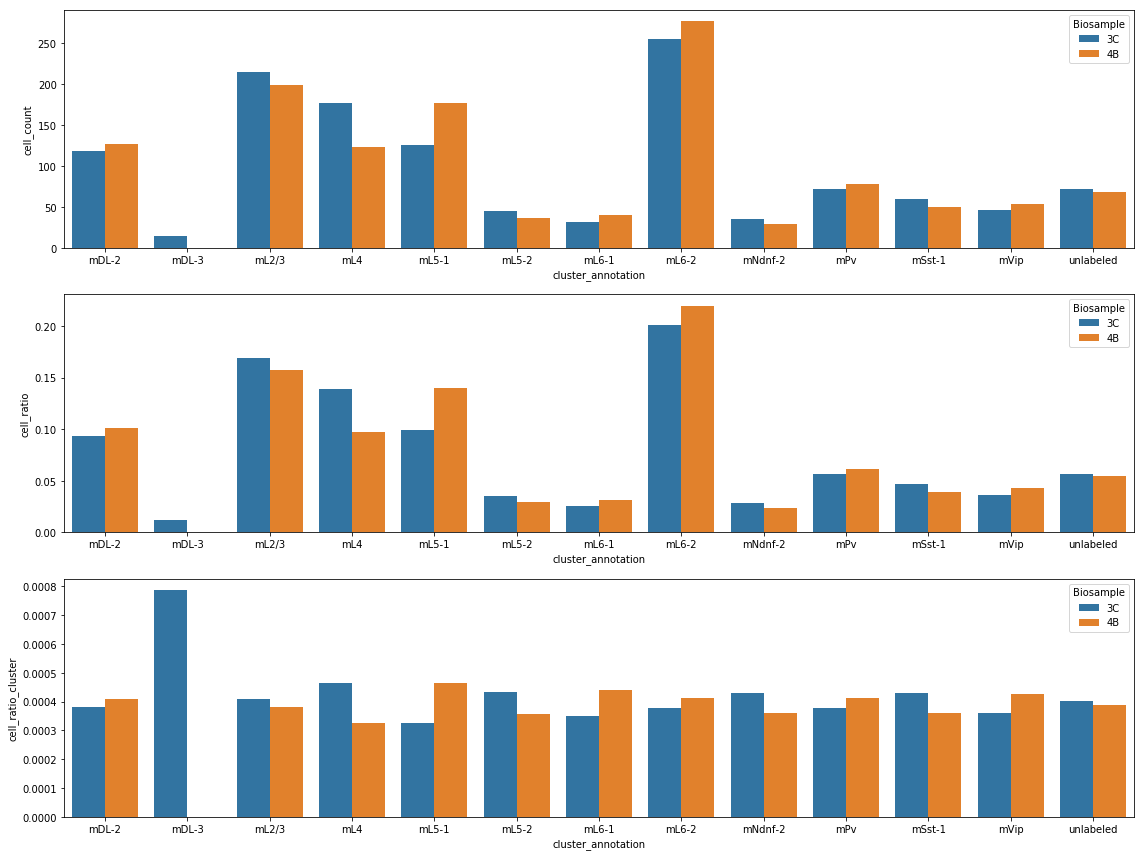

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(16, 12))
ax = axs[0]
sns.barplot(x="cluster_annotation", y="cell_count", hue="Biosample", data=df_counts_new_2, ax=ax)
# ax.set_xticks([])
ax = axs[1]
sns.barplot(x="cluster_annotation", y="cell_ratio", hue="Biosample", data=df_counts_new_2, ax=ax)
# ax.set_xticks([])
ax = axs[2]
sns.barplot(x="cluster_annotation", y="cell_ratio_cluster", hue="Biosample", data=df_counts_new_2, ax=ax)
fig.tight_layout()
plt.show()

In [17]:
df_counts_3 = df_info.groupby(['cell_class', 'Biosample']).count()['mCH/CH'].to_frame()
df_counts_3 = df_counts_3.reset_index(level=['cell_class', 'Biosample'])
df_counts_3.columns = ['cell_class', 'Biosample', 'cell_count']

df_sample_counts = df_info.groupby('Biosample').count()['mCH/CH'].to_frame()
df_sample_counts.columns = ['tc_biosample']
df_counts_new_3 = pd.merge(df_counts_3, df_sample_counts, left_on='Biosample', right_index=True)
df_counts_new_3['cell_ratio'] = df_counts_new_3.cell_count/df_counts_new_3.tc_biosample

df_cluster_counts = df_info.groupby('cell_class').count()['mCH/CH'].to_frame()
df_cluster_counts.columns = ['tc_cluster']
df_counts_new_3 = pd.merge(df_counts_new_3, df_cluster_counts, left_on='cell_class', right_index=True)
df_counts_new_3['cell_ratio_cluster'] = df_counts_new_3.cell_ratio/df_counts_new_3.tc_cluster

df_counts_new_3

cell_class Biosample  cell_count  tc_biosample  cell_ratio  tc_cluster  \
0         Ex        3C         984          1270    0.774803        1964   
1         Ex        4B         980          1261    0.777161        1964   
2       Glia        3C          72          1270    0.056693         141   
3       Glia        4B          69          1261    0.054718         141   
4         In        3C         214          1270    0.168504         426   
5         In        4B         212          1261    0.168121         426   

   cell_ratio_cluster  
0            0.000395  
1            0.000396  
2            0.000402  
3            0.000388  
4            0.000396  
5            0.000395

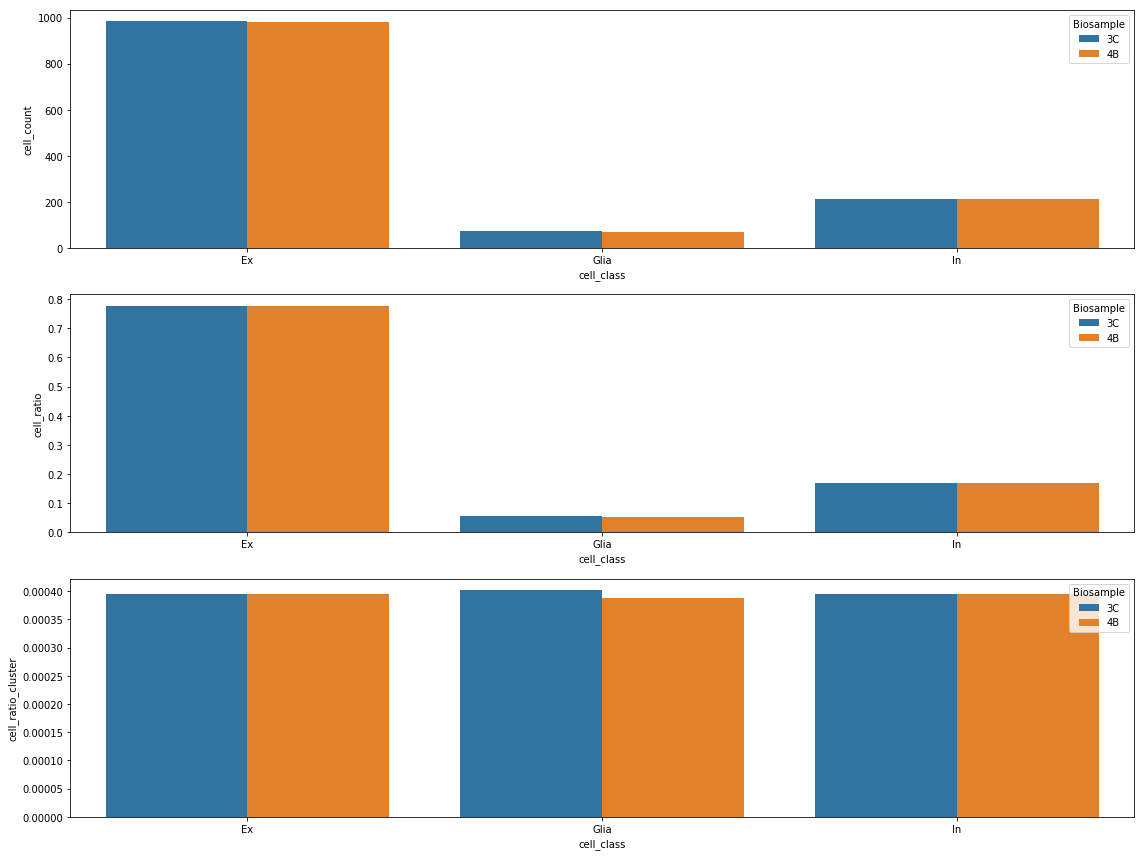

In [18]:
fig, axs = plt.subplots(3, 1, figsize=(16, 12))
ax = axs[0]
sns.barplot(x="cell_class", y="cell_count", hue="Biosample", data=df_counts_new_3, ax=ax)
# ax.set_xticks([])
ax = axs[1]
sns.barplot(x="cell_class", y="cell_ratio", hue="Biosample", data=df_counts_new_3, ax=ax)
# ax.set_xticks([])
ax = axs[2]
sns.barplot(x="cell_class", y="cell_ratio_cluster", hue="Biosample", data=df_counts_new_3, ax=ax)
fig.tight_layout()
plt.show()

# Analysis of variances

In [19]:
def sum_of_square(array):
    dev = array - np.mean(array)
    return np.dot(dev, dev)

# ANOVAs for each gene and each cluster

In [20]:
# ANOVAs for each gene

# sst ssw sr_n

df_sst = pd.DataFrame()
df_ssw = pd.DataFrame()
sr_n = pd.Series()
for idx, df_sub in df_info.groupby('cluster_annotation'):
    cells = df_sub.index.values
    SSt = df_mcc[cells+'_mcc'].apply(sum_of_square, axis=1)
    SSw = 0
    for idx2, df_sub2 in df_sub.groupby('Biosample'):
        cells_bio = df_sub2.index.values
        SSw += df_mcc[cells_bio+'_mcc'].apply(sum_of_square, axis=1)
    df_sst[idx] = SSt 
    df_ssw[idx] = SSw 
    sr_n[idx] = cells.shape[0]
 

In [21]:
# F-stat, p-values

I = df_info['Biosample'].unique().shape[0]
print(str(I) + ' unique categories!')
df_F = ((df_sst - df_ssw)/(I-1))/(df_ssw.divide(sr_n-I, axis=1))
df_p = pd.DataFrame()
for col in df_F.columns:
    d2 = sr_n.loc[col] - I
    df_p[col] = df_F[col].apply(lambda x: stats.f.sf(x, I-1, d2))
df_p.head()

2 unique categories!


mDL-2  mDL-3     mL2/3       mL4     mL5-1  \
gene_id                                                                
ENSMUSG00000051951.5   0.407715    1.0  0.000698  0.816721  0.021385   
ENSMUSG00000089699.1   0.950566    1.0  0.083810  0.857701  0.787076   
ENSMUSG00000102343.1   0.362292    1.0  0.894248  0.819177  0.604382   
ENSMUSG00000025900.12  0.000525    1.0  0.289880  0.088536  0.061744   
ENSMUSG00000025903.14  0.129196    1.0  0.094653  0.633848  0.051084   

                          mL5-2     mL6-1     mL6-2   mNdnf-2       mPv  \
gene_id                                                                   
ENSMUSG00000051951.5   0.702955  0.088886  0.601159  0.880974  0.001794   
ENSMUSG00000089699.1   0.378606  0.289588  0.004366  0.990415  0.037515   
ENSMUSG00000102343.1   0.072015  0.224462  0.827881  0.537620  0.441166   
ENSMUSG00000025900.12  0.132506  0.061503  0.284583  0.583134  0.156195   
ENSMUSG00000025903.14  0.499950  0.198877  0.456778  0.371580  0.875429   

                         mSst-1      mVip  unlabeled  
gene_id                                               
ENSMUSG00000051951.5   0.021392  0.641598   0.283844  
ENSMUSG00000089699.1   0.517381  0.679194   0.580477  
ENSMUSG00000102343.1   0.236586  0.783091   0.407948  
ENSMUSG00000025900.12  0.009569  0.878188   0.001761  
ENSMUSG00000025903.14  0.206689  0.303509   0.964014

In [22]:
# eta-squard and omega squared
df_eta = 1 - df_ssw/df_sst

# om_sqrd = (SSbetween - (DFbetween * MSwithin))/(SStotal + MSwithin)
df_ome = (df_sst - df_ssw - (I-1)*df_ssw.divide(sr_n-I, axis=1))/(df_sst + df_ssw.divide(sr_n-I, axis=1))


def order_df_res(df_res):
    df_res_ordered = pd.DataFrame()
    for col in df_res.columns:
        df_res_ordered[col] = df_res[col].sort_values(ascending=False).values
    return df_res_ordered

## Plots of ANOVA

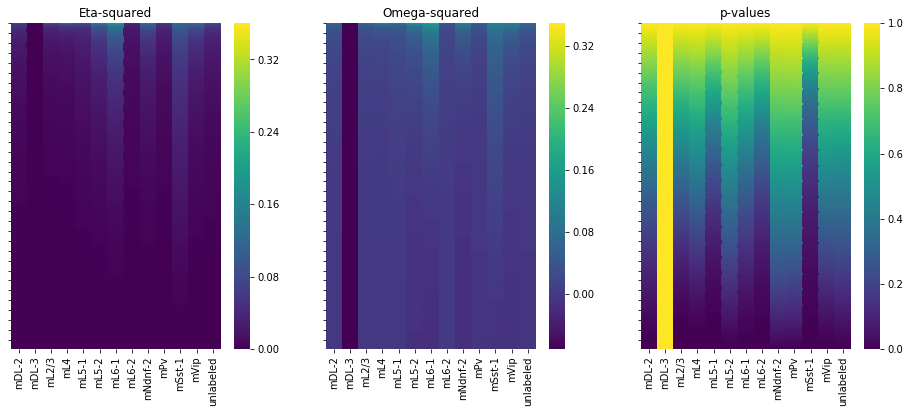

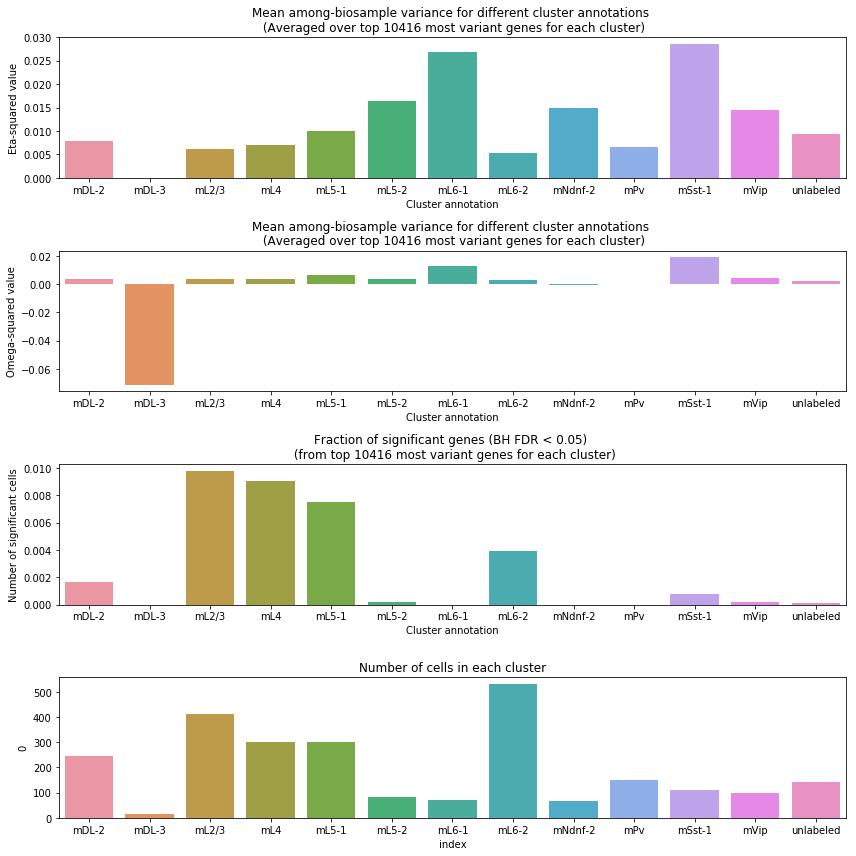

In [23]:
# eta-squared, omega-squared, and p-values 

df_res1 = df_eta
df_res2 = df_ome
df_res3 = df_p
n_top = df_res1.shape[0] 

df_res_ordered1 = order_df_res(df_res1)
df_res_ordered2 = order_df_res(df_res2)
df_res_ordered3 = order_df_res(df_res3)
    
df_plot1 = df_res_ordered1.iloc[:n_top, :].mean(axis=0).to_frame()
df_plot1.reset_index(level=0, inplace=True)
df_plot1.columns = ['Cluster annotation', 'Eta-squared value']

df_plot2 = df_res_ordered2.iloc[:n_top, :].mean(axis=0).to_frame()
df_plot2.reset_index(level=0, inplace=True)
df_plot2.columns = ['Cluster annotation', 'Omega-squared value']

# number of variant genes
df_plot3 = pd.Series()
for col in df_p.columns:
    rejs, *dis = multipletests(df_p[col], alpha=0.05, method='hs')
    df_plot3[col] = rejs.sum()
df_plot3 = (df_plot3/df_p.shape[0]).to_frame().reset_index()
df_plot3.columns = ['Cluster annotation', 'Number of significant cells']


fig, axs = plt.subplots(1, 3, figsize=(16, 6))
ax = axs[0]
sns.heatmap(df_res_ordered1.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('Eta-squared')
ax.set_yticklabels([])
ax = axs[1]
sns.heatmap(df_res_ordered2.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('Omega-squared')
ax.set_yticklabels([])
ax = axs[2]
sns.heatmap(df_res_ordered3.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('p-values')
ax.set_yticklabels([])
plt.show()

fig, axs = plt.subplots(4, 1, figsize=(12, 12))
ax = axs[0]
sns.barplot(x='Cluster annotation', y='Eta-squared value', data=df_plot1, ax=ax)
ax.set_title('Mean among-biosample variance for different cluster annotations \n (Averaged over top %d most variant genes for each cluster)' % n_top)
ax = axs[1]
sns.barplot(x='Cluster annotation', y='Omega-squared value', data=df_plot2, ax=ax)
ax.set_title('Mean among-biosample variance for different cluster annotations \n (Averaged over top %d most variant genes for each cluster)' % n_top)
ax = axs[2]
sns.barplot(x='Cluster annotation', y='Number of significant cells', data=df_plot3, ax=ax)
ax.set_title('Fraction of significant genes (BH FDR < 0.05) \n (from top %d most variant genes for each cluster)' % n_top)
ax = axs[3]
sns.barplot(x='index', y=0, data=sr_n.to_frame().reset_index(), ax=ax)
ax.set_title('Number of cells in each cluster')
fig.tight_layout()
plt.show()



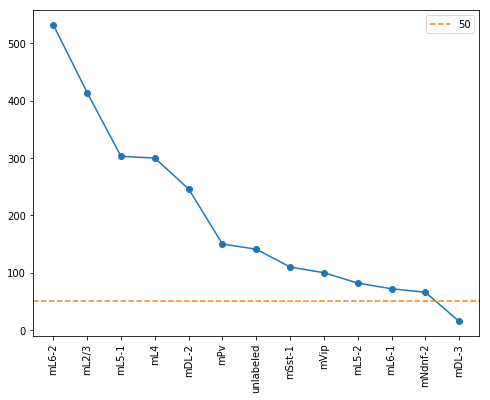

mDL-2        246
mL2/3        414
mL4          300
mL5-1        303
mL5-2         82
mL6-1         72
mL6-2        532
mNdnf-2       66
mPv          150
mSst-1       110
mVip         100
unlabeled    141
dtype: int64

In [24]:
# number of cells in each cluster

sr_n_sorted = sr_n.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8, 6))
# sns.barplot(x='index', y=0, data=sr_n.sort_values(ascending=False).to_frame().reset_index(), ax=ax)
# ax.set_title('Number of cells in each cluster')

ax.plot(sr_n_sorted.values, '-o')
ax.set_xticklabels(sr_n_sorted.index.values, rotation=90)
ax.set_xticks([i for i in range(sr_n.shape[0])])
ax.axhline(y=50, ls='dashed', color='C1', label='50')
ax.legend()
plt.show()

sr_n_tr = sr_n.loc[sr_n.index.isin(sr_n_sorted[(sr_n_sorted > 50)].index)]
sr_n_tr

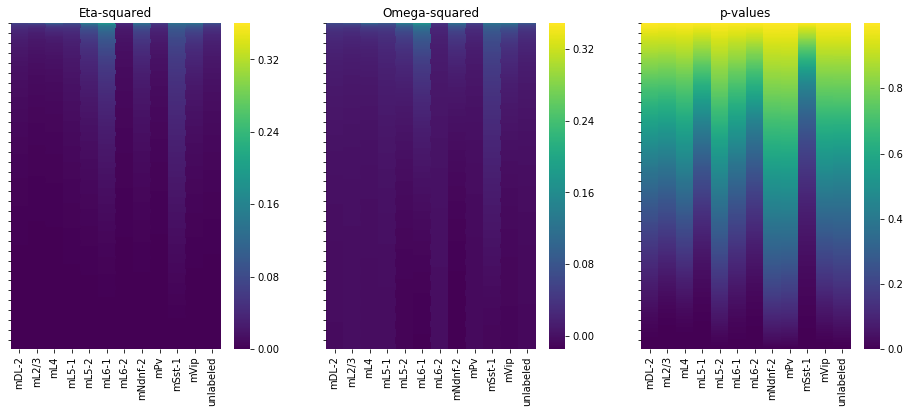

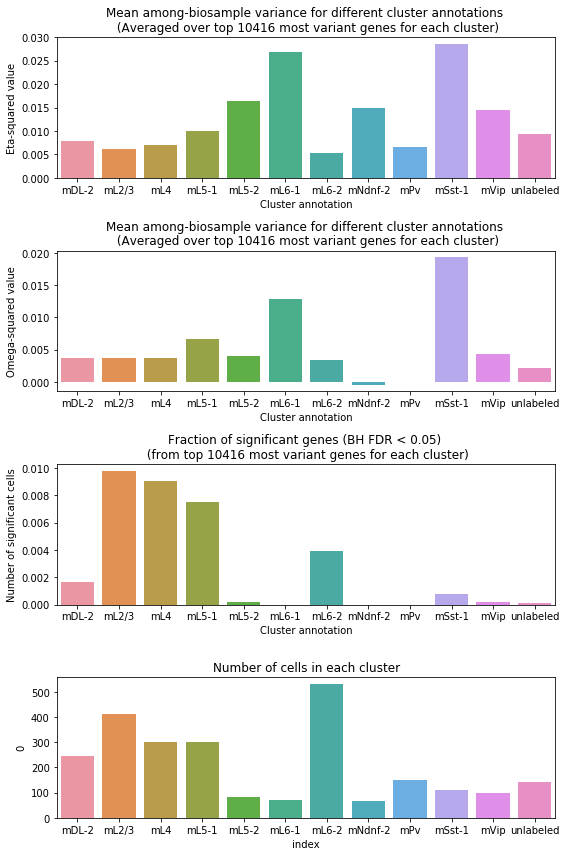

In [25]:
# rerun with truncated set of celltypes

# eta-squared, omega-squared, and p-values 

cell_types_tr = sr_n_tr.index.values  

df_res1 = df_eta[cell_types_tr]
df_res2 = df_ome[cell_types_tr]
df_res3 = df_p[cell_types_tr]
n_top = df_res1.shape[0] 
# n_top = 50 

df_res_ordered1 = order_df_res(df_res1)
df_res_ordered2 = order_df_res(df_res2)
df_res_ordered3 = order_df_res(df_res3)
    
df_plot1 = df_res_ordered1.iloc[:n_top, :].mean(axis=0).to_frame()
df_plot1.reset_index(level=0, inplace=True)
df_plot1.columns = ['Cluster annotation', 'Eta-squared value']

df_plot2 = df_res_ordered2.iloc[:n_top, :].mean(axis=0).to_frame()
df_plot2.reset_index(level=0, inplace=True)
df_plot2.columns = ['Cluster annotation', 'Omega-squared value']

# number of variant genes
df_plot3 = pd.Series()
for col in df_res3.columns:
    rejs, *dis = multipletests(df_res3[col], alpha=0.05, method='hs')
    df_plot3[col] = rejs.sum()
df_plot3 = (df_plot3/df_p.shape[0]).to_frame().reset_index()
df_plot3.columns = ['Cluster annotation', 'Number of significant cells']


fig, axs = plt.subplots(1, 3, figsize=(16, 6))
ax = axs[0]
sns.heatmap(df_res_ordered1.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('Eta-squared')
ax.set_yticklabels([])
ax = axs[1]
sns.heatmap(df_res_ordered2.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('Omega-squared')
ax.set_yticklabels([])
ax = axs[2]
sns.heatmap(df_res_ordered3.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('p-values')
ax.set_yticklabels([])
plt.show()

fig, axs = plt.subplots(4, 1, figsize=(8, 12))
ax = axs[0]
sns.barplot(x='Cluster annotation', y='Eta-squared value', data=df_plot1, ax=ax)
ax.set_title('Mean among-biosample variance for different cluster annotations \n (Averaged over top %d most variant genes for each cluster)' % n_top)
ax = axs[1]
sns.barplot(x='Cluster annotation', y='Omega-squared value', data=df_plot2, ax=ax)
ax.set_title('Mean among-biosample variance for different cluster annotations \n (Averaged over top %d most variant genes for each cluster)' % n_top)
ax = axs[2]
sns.barplot(x='Cluster annotation', y='Number of significant cells', data=df_plot3, ax=ax)
ax.set_title('Fraction of significant genes (BH FDR < 0.05) \n (from top %d most variant genes for each cluster)' % n_top)
ax = axs[3]
sns.barplot(x='index', y=0, data=sr_n_tr.to_frame().reset_index(), ax=ax)
ax.set_title('Number of cells in each cluster')
fig.tight_layout()
plt.show()


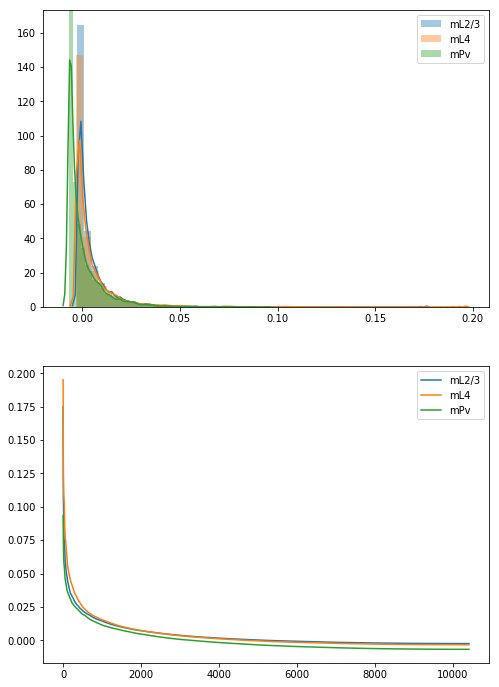

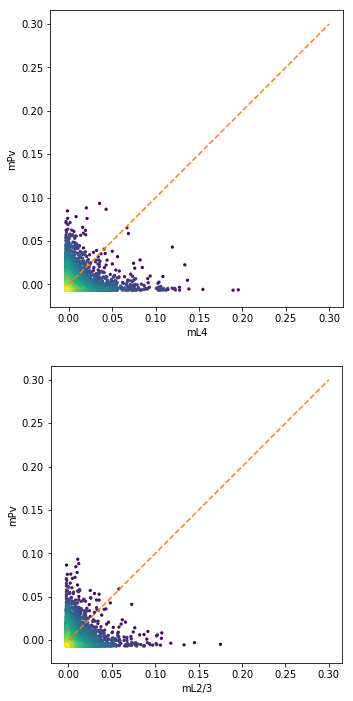

In [26]:
# eta-squared 
df_res = df_ome
n_top = df_res.shape[0] 

df_res_ordered = pd.DataFrame()
for col in df_res.columns:
    df_res_ordered[col] = df_res[col].sort_values(ascending=False).values
    
fig, axs = plt.subplots(2, 1, figsize=(8, 12))
ax = axs[0]
sns.distplot(df_res['mL2/3'].values, ax=ax, label='mL2/3')
sns.distplot(df_res['mL4'].values, ax=ax, label='mL4')
# sns.distplot(df_res['hL5-2'].values, ax=ax, label='hL5-2')
sns.distplot(df_res['mPv'].values, ax=ax, label='mPv')
# sns.distplot(df_res['hNdnf'].values, ax=ax, label='hNdnf')
ax.legend()

ax = axs[1]
ax.plot(df_res_ordered['mL2/3'].values, label='mL2/3')
ax.plot(df_res_ordered['mL4'].values, label='mL4')
# ax.plot(df_res_ordered['hL5-2'].values, label='hL5-2')
ax.plot(df_res_ordered['mPv'].values, label='mPv')
# ax.plot(df_res_ordered['hNdnf'].values, label='hNdnf')
# ax.set_yscale('log')
ax.legend()
plt.show()


fig, axs = plt.subplots(2, 1, figsize=(8, 12))
ax = axs[0]
xy = np.vstack([df_res['mL4'].values, df_res['mPv'].values]) 
z = gaussian_kde(xy)(xy)
ax.scatter(df_res['mL4'].values, df_res['mPv'].values, c=np.log10(z), s=5)
ax.set_xlabel('mL4')
ax.set_ylabel('mPv')
line_x = np.arange(0, 0.4, 0.1)
line_y = np.arange(0, 0.4, 0.1)
ax.plot(line_x, line_y, '--', color='C1')
ax.set_aspect('equal')

ax = axs[1]
xy = np.vstack([df_res['mL2/3'].values, df_res['mPv'].values]) 
z = gaussian_kde(xy)(xy)
ax.scatter(df_res['mL2/3'].values, df_res['mPv'].values, c=np.log10(z), s=5)
ax.set_xlabel('mL2/3')
ax.set_ylabel('mPv')
line_x = np.arange(0, 0.4, 0.1)
line_y = np.arange(0, 0.4, 0.1)
ax.plot(line_x, line_y, '--', color='C1')
ax.set_aspect('equal')
plt.show()



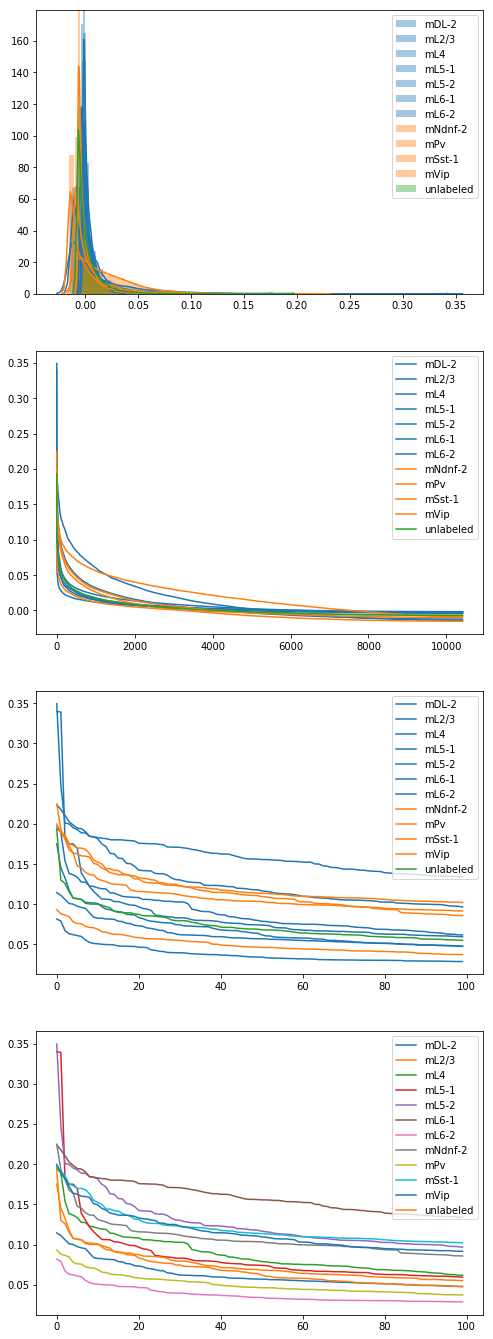

In [27]:
# eta-squared

# df_cell_class.loc[cell_types_tr].groupby('cell_class')

cell_types_tr = sr_n_tr.index.tolist()
df_res = df_ome[cell_types_tr] 
n_top = df_res.shape[0] 

df_res_ordered = pd.DataFrame()
for col in df_res.columns:
    df_res_ordered[col] = df_res[col].sort_values(ascending=False).values
    
fig, axs = plt.subplots(4, 1, figsize=(8, 6*4))
ax = axs[0]
for col in df_res.columns:
    if df_cell_class.loc[col, 'cell_class'] == 'Ex':
        sns.distplot(df_res[col].values, ax=ax, label=col, color='C0')
    elif df_cell_class.loc[col, 'cell_class'] == 'In':
        sns.distplot(df_res[col].values, ax=ax, label=col, color='C1')
    elif df_cell_class.loc[col, 'cell_class'] == 'Glia':
        sns.distplot(df_res[col].values, ax=ax, label=col, color='C2')
ax.legend()

ax = axs[1]
for col in df_res.columns:
    if df_cell_class.loc[col, 'cell_class'] == 'Ex':
        ax.plot(df_res_ordered[col].values, label=col, color='C0')
    elif df_cell_class.loc[col, 'cell_class'] == 'In':
        ax.plot(df_res_ordered[col].values, label=col, color='C1')
    elif df_cell_class.loc[col, 'cell_class'] == 'Glia':
        ax.plot(df_res_ordered[col].values, label=col, color='C2')
ax.legend()

ax = axs[2]
n_tops = 100
for col in df_res.columns:
    if df_cell_class.loc[col, 'cell_class'] == 'Ex':
        ax.plot(df_res_ordered[col].values[:n_tops], label=col, color='C0')
    elif df_cell_class.loc[col, 'cell_class'] == 'In':
        ax.plot(df_res_ordered[col].values[:n_tops], label=col, color='C1')
    elif df_cell_class.loc[col, 'cell_class'] == 'Glia':
        ax.plot(df_res_ordered[col].values[:n_tops], label=col, color='C2')
ax.legend()

ax = axs[3]
n_tops = 100
for col in df_res.columns:
    ax.plot(df_res_ordered[col].values[:n_tops], label=col)
#     if df_cell_class.loc[col, 'cell_class'] == 'Ex':
#         ax.plot(df_res_ordered[col].values[:n_tops], label=col, color='C0')
#     elif df_cell_class.loc[col, 'cell_class'] == 'In':
#         ax.plot(df_res_ordered[col].values[:n_tops], label=col, color='C1')
#     elif df_cell_class.loc[col, 'cell_class'] == 'Glia':
#         ax.plot(df_res_ordered[col].values[:n_tops], label=col, color='C2')
ax.legend()
plt.show()



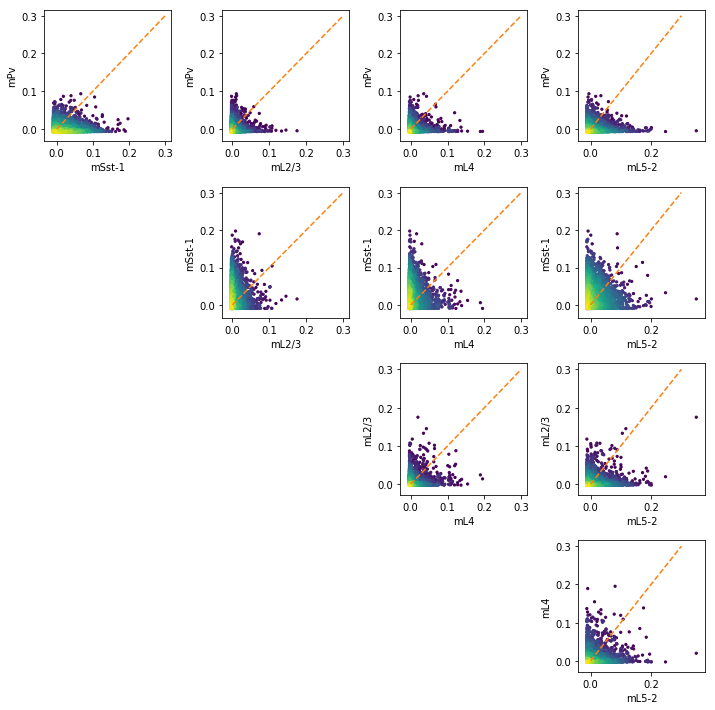

In [28]:
# hPv-1, hSst-2, hL2/3, hL4, hL5-2

cell_types_tr2 = ['mPv', 'mSst-1', 'mL2/3', 'mL4', 'mL5-2']
n = len(cell_types_tr2)

fig, axs = plt.subplots(n, n, figsize=(12, 12))
for i, j in zip(*np.tril_indices_from(axs, k=0)):
    axs[i, j].set_visible(False)
for i, j in zip(*np.triu_indices_from(axs, k=1)):
    ax = axs[i, j]
    cti = cell_types_tr2[j]
    ctj = cell_types_tr2[i]
    xy = np.vstack([df_res[cti].values, df_res[ctj].values]) 
    z = gaussian_kde(xy)(xy)
    ax.scatter(df_res[cti].values, df_res[ctj].values, c=np.log10(z), s=5)
    ax.set_xlabel(cti)
    ax.set_ylabel(ctj)
    line_x = np.arange(0, 0.4, 0.1)
    line_y = np.arange(0, 0.4, 0.1)
    ax.plot(line_x, line_y, '--', color='C1')
    ax.set_aspect('auto')
    
fig.tight_layout()
plt.show()



# Look at one cell type (hL4)

In [29]:
# repeat with different n 

# take top n genes for hL4

# classifier LDA   

# evaluate

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn import metrics 
from sklearn.model_selection import KFold

# number of cells from each biosample

def get_data(celltype, sample_n=None):
    cells = df_info[df_info.cluster_annotation==celltype].index.values
#     cells_v1 = df_info[(df_info.cluster_annotation==celltype) & (df_info.Biosample=='MB_v1')].index.values
#     cells_EA = df_info[(df_info.cluster_annotation==celltype) & (df_info.Biosample=='MB_EA')].index.values
#     cells_EB = df_info[(df_info.cluster_annotation==celltype) & (df_info.Biosample=='MB_EB')].index.values
#     print(np.asarray([cells_v1.shape[0], cells_EA.shape[0], cells_EB.shape[0]])/cells.shape[0])

    # generate data
    cells = df_info[df_info['cluster_annotation']==celltype].index.values
    y = df_info.loc[cells, 'Biosample']
    X0 = df_mcc.loc[df_p.sample(frac=1).index.values, cells+'_mcc'].T 
    X0.index = [cell[:-len('_mcc')] for cell in X0.index]
    X1 = df_mcc.loc[df_p[celltype].sort_values().index.values, cells+'_mcc'].T 
    X1.index = [cell[:-len('_mcc')] for cell in X1.index]
    df_xy0 = pd.merge(X0, y.to_frame(), left_index=True, right_index=True)
    df_xy1 = pd.merge(X1, y.to_frame(), left_index=True, right_index=True)
#     print(df_xy0.shape)
#     print(df_xy1.shape)
    if not sample_n:
        return df_xy0, df_xy1
    else:
        return df_xy0.sample(sample_n), df_xy0.sample(sample_n)
    

In [30]:
def LDA_xvalid(df_xy, n_splits=5, n_tops=np.arange(1, 100, 2), classifier='LDA'):
    """
    X = regex="^ENS"
    y = "Biosample"
    
    """
    # 5-fold cv with LDA
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    # n_tops = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]

    mean_accs = []
    mean_f1_micros = []
    mean_f1_macros = []
    split_scheme = list(kf.split(df_xy))
    for n_top in n_tops:
        accs = []
        f1_micros = []
        f1_macros = []
        for i, (train_index, test_index) in enumerate(split_scheme):
            X_train = df_xy.iloc[train_index, :n_top].filter(regex='^ENS')
            X_test = df_xy.iloc[test_index, :n_top].filter(regex='^ENS')
            y_train = df_xy.iloc[train_index, :].Biosample
            y_test = df_xy.iloc[test_index, :].Biosample

            # train LDA model
            if classifier == 'LDA':
                lda = LDA().fit(X_train, y_train)
                y_pred = lda.predict(X_test)
            elif classifier == 'RFC':
                rfc = RFC(n_estimators=10, random_state=1).fit(X_train, y_train)
                y_pred = rfc.predict(X_test)

            # evaluate
            acc = metrics.accuracy_score(y_test, y_pred)
            f1_micro = metrics.f1_score(y_test, y_pred, average='micro')
            f1_macro = metrics.f1_score(y_test, y_pred, average='macro')
            accs.append(acc)
            f1_micros.append(f1_micro)
            f1_macros.append(f1_macro)

    #         if i == 0:
    #             conf_mat = metrics.confusion_matrix(y_test, y_pred)
    #             print(conf_mat)


        mean_acc = np.mean(accs)
        mean_f1_micro = np.mean(f1_micros)
        mean_f1_macro = np.mean(f1_macros)

        mean_accs.append(mean_acc)
        mean_f1_micros.append(mean_f1_micro)
        mean_f1_macros.append(mean_f1_macro)

    return mean_accs, mean_f1_micros, mean_f1_macros


In [31]:
def LDA_pca_xvalid(X, y, n_splits=5, classifier='LDA', metric_auroc=False):
    """
    X = regex="^\("
    y = "Biosample"
    
    """
    # 5-fold cv with LDA
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    mean_accs = []
    mean_f1_micros = []
    mean_f1_macros = []
    if metric_auroc:
        mean_aurocs = []
    split_scheme = list(kf.split(y))
 
    accs = []
    f1_micros = []
    f1_macros = []
    if metric_auroc:
        aurocs = []
    for i, (train_index, test_index) in enumerate(split_scheme):
        X_train = X[train_index] 
        X_test = X[test_index] 
        y_train = y[train_index] 
        y_test = y[test_index] 

        # train LDA model
        if classifier == 'LDA':
            res_fit = LDA().fit(X_train, y_train)
            y_pred = res_fit.predict(X_test)
            y_pred_p = res_fit.predict_proba(X_test)[:,1]
        elif classifier == 'RFC':
            res_fit = RFC(n_estimators=10, random_state=1).fit(X_train, y_train)
            y_pred = res_fit.predict(X_test)
            y_pred_p = res_fit.predict_proba(X_test)[:,1]

        # evaluate
        acc = metrics.accuracy_score(y_test, y_pred)
        f1_micro = metrics.f1_score(y_test, y_pred, average='micro')
        f1_macro = metrics.f1_score(y_test, y_pred, average='macro')
        
        accs.append(acc)
        f1_micros.append(f1_micro)
        f1_macros.append(f1_macro)

        if metric_auroc:
            y_factors, y_labels = pd.factorize(y_test) 
            fpr, tpr, thresholds = metrics.roc_curve(y_factors, y_pred_p)
            auroc = metrics.auc(fpr, tpr)
            aurocs.append(auroc)
#         if i == 0:
#             conf_mat = metrics.confusion_matrix(y_test, y_pred)
#             print(conf_mat)


    mean_acc = np.mean(accs)
    mean_f1_micro = np.mean(f1_micros)
    mean_f1_macro = np.mean(f1_macros)
    if metric_auroc:
        mean_auroc = np.mean(aurocs)
    if metric_auroc:
        return mean_acc, mean_f1_micro, mean_f1_macro, mean_auroc
    else:
        return mean_acc, mean_f1_micro, mean_f1_macro


In [52]:
# PCA regression
# top n PCs
n_tops = [5, 10, 20, 30, 40, 50]
# n_tops = [5, 10, 15, 20, 25, 30]

sample_n = None 
# sr_n_tr = sr_n.loc[sr_n.index.isin(sr_n_sorted[(sr_n_sorted >=50)].index)]
cell_types_tr2 = sr_n_tr.index.values

res_dct = OrderedDict()
for celltype in cell_types_tr2:
    df_xy0, df_xy1 = get_data(celltype, sample_n=sample_n)
    X = df_xy1.filter(regex='^ENS').values
    y = df_xy1.Biosample.values
    
    accs = []
    f1_mis = []
    f1_mas = []
    aurocs = []
    for n_top in n_tops:
        
        pca = PCA(n_components=n_top)
        pcX = pca.fit_transform(X)

        acc, f1_mi, f1_ma, auroc = LDA_pca_xvalid(pcX, y, classifier='LDA', metric_auroc=True)
        accs.append(acc)
        f1_mis.append(f1_mi)
        f1_mas.append(f1_ma)
        aurocs.append(auroc)
    
    res_dct[celltype] = (accs, f1_mis, f1_mas, aurocs) 

/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:510: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


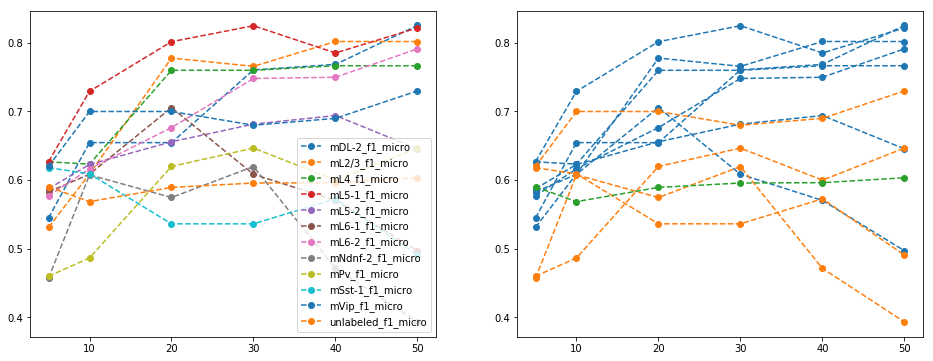

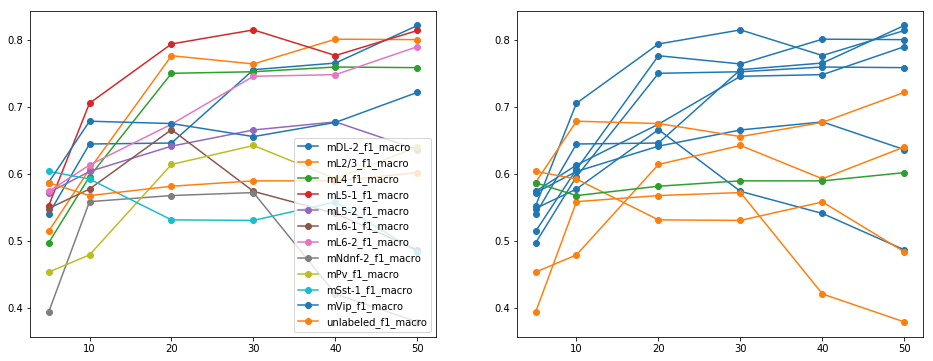

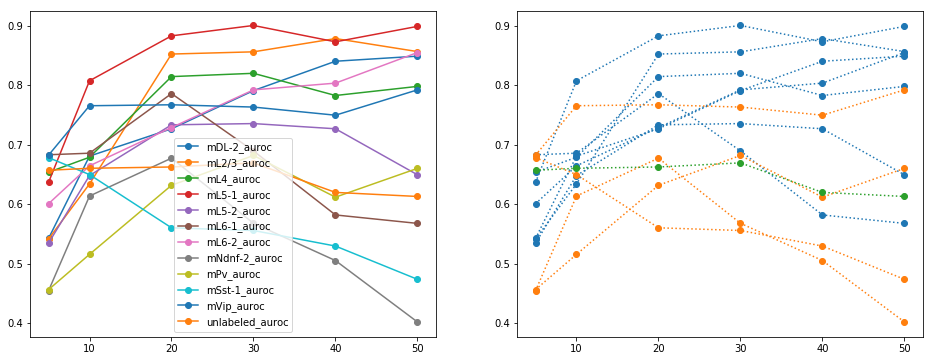

In [53]:
# plot PCA regression results
# cell_types_tr2 = sr_n_tr.index.values
# n_tops = [5, 10, 20, 30, 40, 50]

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

# micro
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
ax = axs[0]
for i, celltype in enumerate(cell_types_tr2):
    ax.plot(n_tops, res_dct[celltype][1], '--o', color=colors[i%len(colors)], label='{}_f1_micro'.format(celltype))
#     ax.plot(n_tops, res_dct[celltype][2], '-o', color=colors[i%len(colors)], label='{}_f1_macro'.format(celltype))
#     ax.plot(n_tops, res_dct[celltype][3], ':o', color=colors[i%len(colors)], label='{}_auroc'.format(celltype))
ax.legend()

ax = axs[1]
for i, celltype in enumerate(cell_types_tr2):
    if celltype in df_cell_class[df_cell_class.cell_class=='Ex'].index.values:
        c = 'C0'
    elif celltype in df_cell_class[df_cell_class.cell_class=='In'].index.values:
        c = 'C1'
    elif celltype in df_cell_class[df_cell_class.cell_class=='Glia'].index.values:
        c = 'C2'
    else:
        c = 'C7'
    ax.plot(n_tops, res_dct[celltype][1], '--o', color=c, label='{}_f1_micro'.format(celltype))
#     ax.plot(n_tops, res_dct[celltype][2], '-o', color=c, label='{}_f1_macro'.format(celltype))
#     ax.plot(n_tops, res_dct[celltype][3], ':o', color=c, label='{}_auroc'.format(celltype))
# ax.legend()
plt.show()


# macro
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
ax = axs[0]
for i, celltype in enumerate(cell_types_tr2):
    ax.plot(n_tops, res_dct[celltype][2], '-o', color=colors[i%len(colors)], label='{}_f1_macro'.format(celltype))
ax.legend()

ax = axs[1]
for i, celltype in enumerate(cell_types_tr2):
    if celltype in df_cell_class[df_cell_class.cell_class=='Ex'].index.values:
        c = 'C0'
    elif celltype in df_cell_class[df_cell_class.cell_class=='In'].index.values:
        c = 'C1'
    elif celltype in df_cell_class[df_cell_class.cell_class=='Glia'].index.values:
        c = 'C2'
    else:
        c = 'C7'
    ax.plot(n_tops, res_dct[celltype][2], '-o', color=c, label='{}_f1_macro'.format(celltype))
# ax.legend()
plt.show()


# auroc 
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
ax = axs[0]
for i, celltype in enumerate(cell_types_tr2):
    ax.plot(n_tops, res_dct[celltype][3], '-o', color=colors[i%len(colors)], label='{}_auroc'.format(celltype))
ax.legend()

ax = axs[1]
for i, celltype in enumerate(cell_types_tr2):
    if celltype in df_cell_class[df_cell_class.cell_class=='Ex'].index.values:
        c = 'C0'
    elif celltype in df_cell_class[df_cell_class.cell_class=='In'].index.values:
        c = 'C1'
    elif celltype in df_cell_class[df_cell_class.cell_class=='Glia'].index.values:
        c = 'C2'
    else:
        c = 'C7'
    ax.plot(n_tops, res_dct[celltype][3], ':o', color=c, label='{}_auroc'.format(celltype))
# ax.legend()
plt.show()

/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


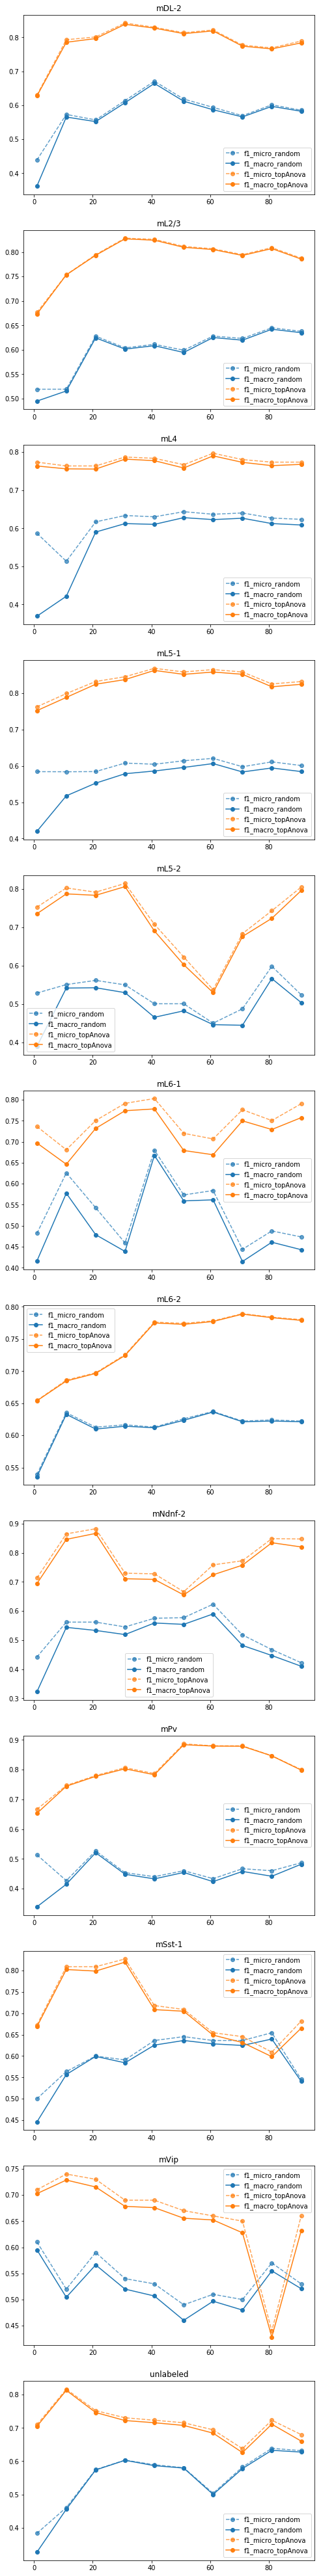

In [43]:
# LDA top genes
n = len(cell_types_tr2)
n_tops = np.arange(1, 100, 10)

fig, axs = plt.subplots(n, 1, figsize=(8, 6*n))
for celltype, ax in zip(cell_types_tr2, axs):
    
    df_xy0, df_xy1 = get_data(celltype)
    accs0, f1_micros0, f1_macros0 = LDA_xvalid(df_xy0, n_tops=n_tops, classifier='LDA')
    accs1, f1_micros1, f1_macros1 = LDA_xvalid(df_xy1, n_tops=n_tops, classifier='LDA')

    ax.plot(n_tops, f1_micros0, '--o', label='f1_micro_random', color='C0', alpha=0.7)
    ax.plot(n_tops, f1_macros0, '-o', label='f1_macro_random', color='C0')
    ax.plot(n_tops, f1_micros1, '--o', label='f1_micro_topAnova', color='C1', alpha=0.7)
    ax.plot(n_tops, f1_macros1, '-o', label='f1_macro_topAnova', color='C1')
    ax.set_title(celltype)
    ax.legend()
plt.show()

In [35]:
# What are the top 30 genes?
n_top = 20
top_genes = pd.DataFrame()
for celltype in cell_types_tr2:
    sr_top_genes = df_gene.loc[df_p[celltype].sort_values().index.values[:n_top], 'geneName']
    top_genes[celltype] = sr_top_genes.values
top_genes

mDL-2          mL2/3      mL4    mL5-1     mL5-2          mL6-1  \
0   Gm12374          Tenm2   Kcnip4    Tenm2     Tenm2        Gm20458   
1    Bcl11a          Cdh11    Rcan2   Zbtb16   Gm13919         Unc13c   
2    Skint5        Runx1t1     Lmf1     Nfix  Arhgap15       BB557941   
3   Runx1t1         Nkain2   Zbtb16    Chrm3     Dsg1a         Pik3cb   
4     Cdh11        Gm42416   Gabra5   Rnf150    Fam78b          Dip2b   
5     Pcdh9           Etv6    Apbb2    Cdh11       Lpp         Dcbld2   
6     Pank1          Cadm2     Cdh2    Pcdh9     Fstl5           Sys1   
7     Cpne5        Gm37013    Galk2    Dleu2    Ankef1           Gnal   
8      Vwc2        Fam135b   Adgrl2      Ntm     Rad18        Gm11639   
9     Chrm3        Gm37388    Adcy1    Pde1a      Nfix          Vwc2l   
10  Gm42416          Csmd3    Itpr1   Pcdh15   Dennd1a          Cntn6   
11    Asap1          Gria4   Hivep1  Gm42416    Zbtb16         Zfp451   
12     Dner        Plekha5    Ric8b    Terf1   Gm26573          Ppard   
13   Zfp935            Ntm   Adora1    Opcml      Pcp4         Lrrc4c   
14    Tenm2           Sfi1    Kcnk2    Arnt2     Itpk1          Rgs20   
15   Zbtb16  C230088H06Rik    Pcdh7  Gm37013    Map3k5           Snph   
16  Gm37013           Cdh8     Enah   Brinp1     Htr2a  D830032E09Rik   
17  Gm37388         Adgrl2   Shisa9  Gm37388     Foxp2        Il18rap   
18  Gm16028           Nav3    Lrfn2     Grm3     Dscam  4833422C13Rik   
19     Chd1          Pde1a  Rhobtb3  Fam135b     Dock4          Rell1   

         mL6-2        mNdnf-2            mPv         mSst-1     mVip  \
0        Grik4         Polr1a        Ankrd17           Itch  Rps6ka2   
1         Cblb  C230088H06Rik       Mapk8ip3         Skint5    Syne1   
2          Kit  4933406K04Rik          Anxa6          Ints1   Zbtb7c   
3       Elavl2          Nudt3          Gsk3b         Zfp738  Galnt18   
4        Cemip        Gm20426           Aff4        Cacna1a   Ctnnd2   
5        Grid1          Ap2a1          Kif5c         Ikbkap    Frem1   
6       Klhl29         Elmod1            Dbt         Snap47     Tcf4   
7        Lypd1        Gm27187        Gm21738         Cep350     Numb   
8         Sdk1          Ppme1         Alkbh3          Rock2  Cttnbp2   
9        Ears2            Gns          Arih1        Gm26733  Slc44a5   
10         Ust           Raf1          Fnip2         Csrnp3     Mgll   
11      Sh3rf1        Slco4c1     CT030254.2  9230109A22Rik    Nr3c2   
12      Pappa2          Dmxl1         Inpp5a         Gm3839  Fam19a5   
13      Hs3st2       Sorbs2os           Rbm6          Pi4ka   Nlrp4e   
14       Bicc1        Gm26733          Srrm4           Pum1   Scarb2   
15  D7Ertd443e           Sfi1           Sdha  2900026A02Rik    Ift57   
16     Cntnap4            Lpo        Tmem268        Slc7a11     Zhx3   
17       Meis2        Gm31045  4932415D10Rik           Mbd5    Snx24   
18      Mapk10           Ggt5        Sult2a4          Acsm2   Ppp4r4   
19       Ajap1           Fntb         Zfp936        Gm45716    Sgip1   

        unlabeled  
0         Gm26573  
1            Iqcm  
2            Sfi1  
3            Rbm6  
4          Nup155  
5           Snrpn  
6         Slc12a2  
7        Vmn2r120  
8            Mug2  
9          Gm4924  
10         Nlrp9c  
11  C130026I21Rik  
12         Skint5  
13           Drg1  
14        Gm28526  
15          Enpp2  
16         Grin2a  
17        Sult2a3  
18  4930590L20Rik  
19         Sema3a

In [36]:
# What are the genes 
genes, counts = np.unique(top_genes.values.flatten(), return_counts=True)
top_genes_stats = pd.DataFrame()
top_genes_stats['gene_name'] = genes
top_genes_stats['number_of_occurance'] = counts

# filter out genes with low ranges
res = []
for gene_name in top_genes_stats.gene_name:
    gene_id = df_gene[df_gene.gene_name==gene_name].index.values[0]
    gene_table = id2table(gene_id)
    sql = """SELECT cell_name, mCH, CH, dataset, {}, {}
            FROM {} 
            JOIN cells 
            ON {}.cell_id = cells.cell_id
            JOIN {}
            ON {}.cell_id = cells.cell_id""".format(cluster_col, annot_col, gene_table, gene_table, ens, ens)
    dfg = pd.read_sql(sql, engine)
    dfg['mCH/CH'] = dfg.mCH/dfg.CH
    dfg['region'] = [dataset[len('CEMBA_'):-len('_171206')] for dataset in dfg['dataset']]
    dfg[annot_col] = dfg[annot_col].fillna('unlabeled')
    
    mcc_range = np.nanpercentile(dfg['mCH/CH'].values, 99) - np.nanpercentile(dfg['mCH/CH'].values, 1)
    res.append({'gene_name': gene_name, 'mCH_range': mcc_range})
res = pd.DataFrame(res)

top_genes_stats = pd.merge(top_genes_stats, res, on='gene_name')
top_genes_stats = top_genes_stats.sort_values('number_of_occurance', ascending=False)
top_genes_stats.head()

gene_name  number_of_occurance  mCH_range
195     Tenm2                    4   0.066081
203    Zbtb16                    4   0.053493
179    Skint5                    3   0.016424
32      Cdh11                    3   0.047758
175      Sfi1                    3   0.008720

In [37]:
# plt.plot(top_genes_stats['mCH_range'].values)
# plt.plot()
# top_genes_stats['mCH_range'].values.shape
top_genes_stats[top_genes_stats['mCH_range']>0.04].shape

(132, 3)

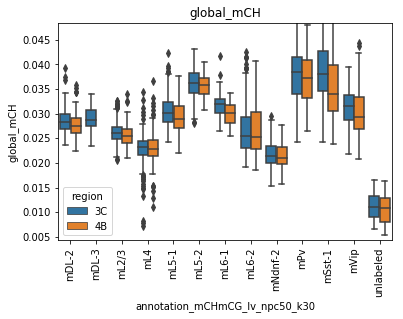

In [38]:
# global level

sql = """SELECT cell_name, global_mCH, dataset, {}, {}
        FROM cells 
        JOIN {}
        ON {}.cell_id = cells.cell_id""".format(cluster_col, annot_col, ens, ens)
dfg = pd.read_sql(sql, engine)
dfg['region'] = [dataset[len('CEMBA_'):-len('_171206')] for dataset in dfg['dataset']]
dfg[annot_col] = dfg[annot_col].fillna('unlabeled')
order = sorted(dfg[annot_col].unique().tolist())

fig, ax = plt.subplots()
sns.boxplot(x=annot_col, y='global_mCH', hue='region', order=order, data=dfg, ax=ax)
yrange = [np.nanpercentile(dfg['global_mCH'].values, 1), np.nanpercentile(dfg['global_mCH'].values, 99)]
yrange[0] = yrange[0] - 0.1*(yrange[1] - yrange[0])
yrange[1] = yrange[1] + 0.1*(yrange[1] - yrange[0])
ax.set_ylim(yrange)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('global_mCH')
plt.show()

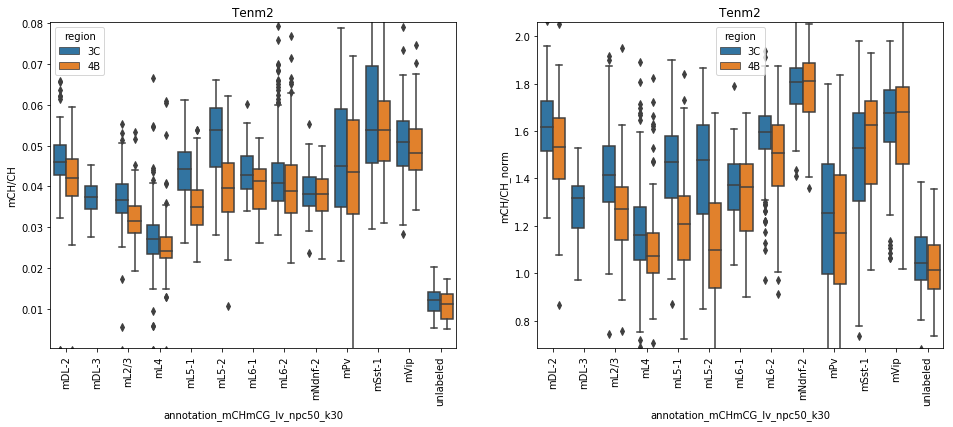

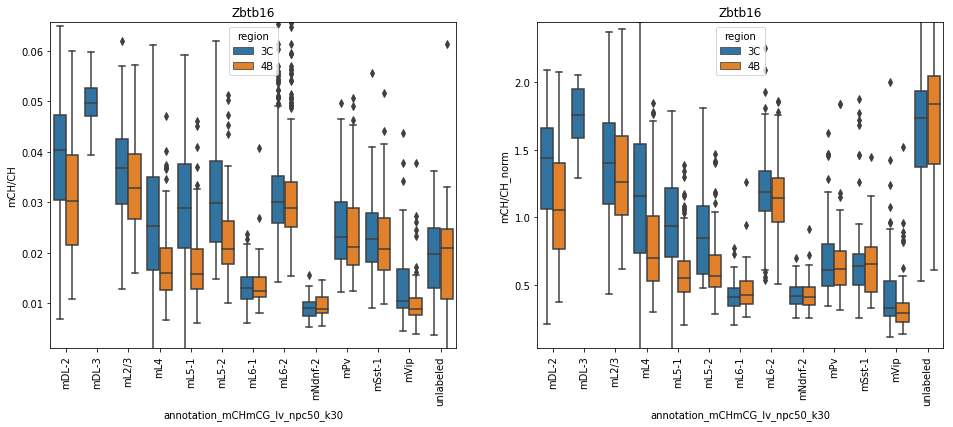

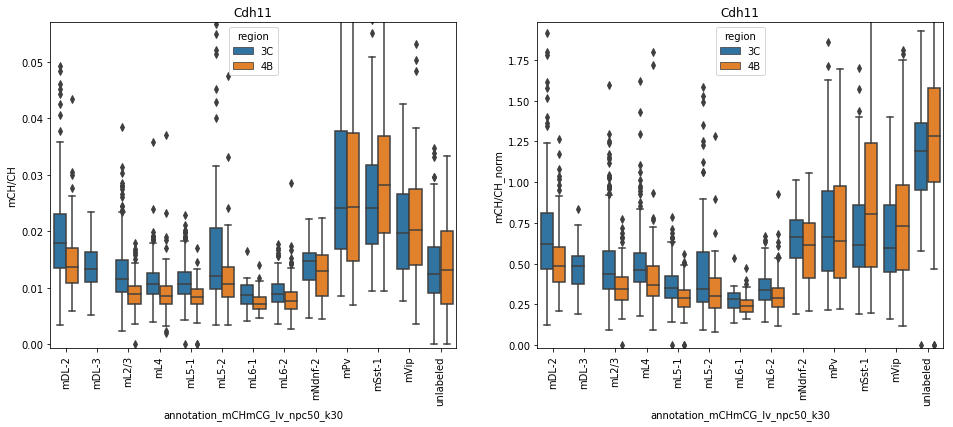

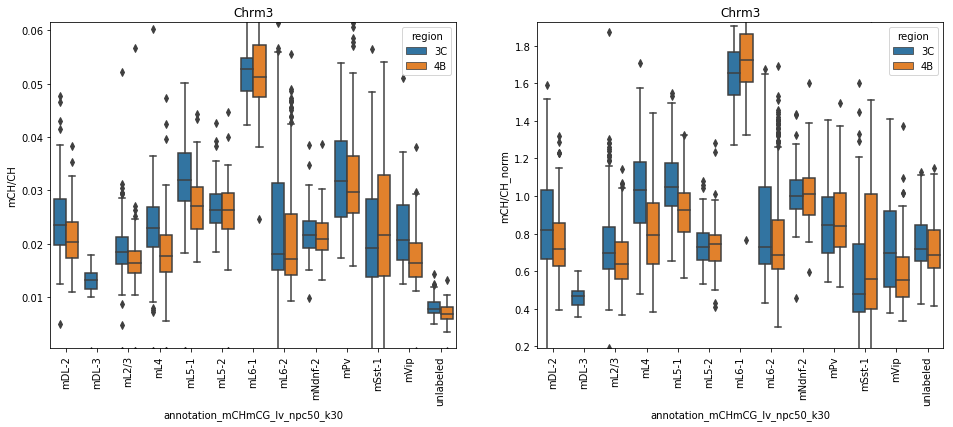

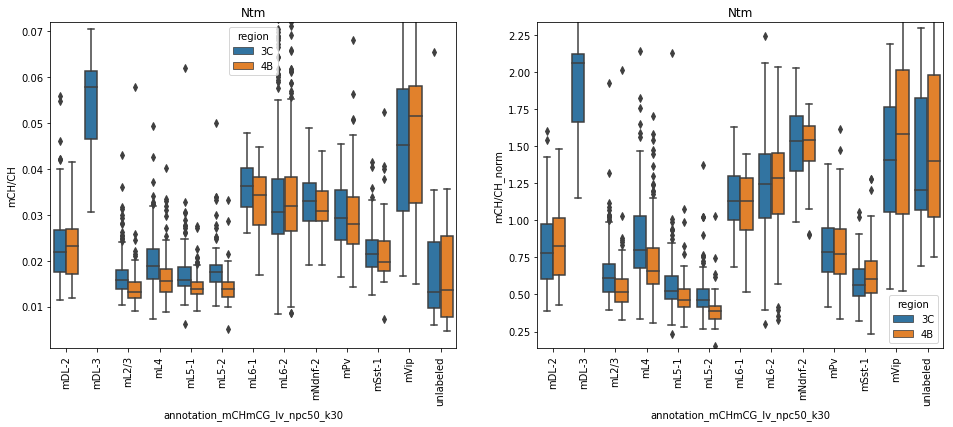

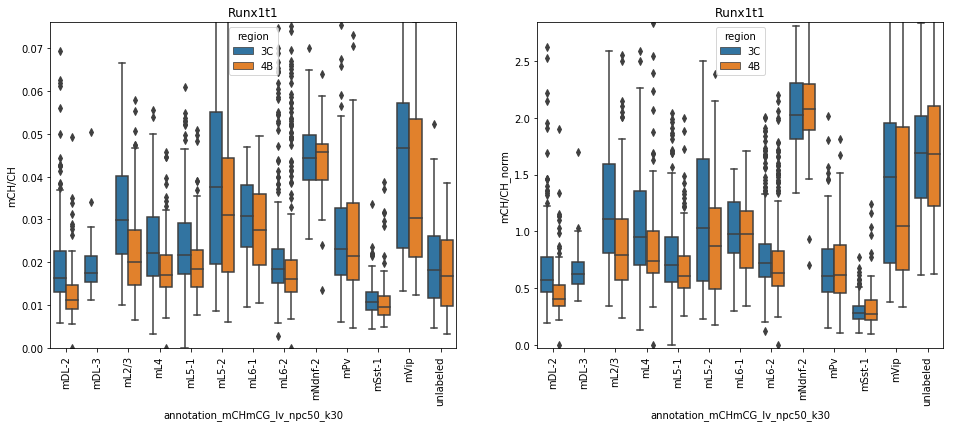

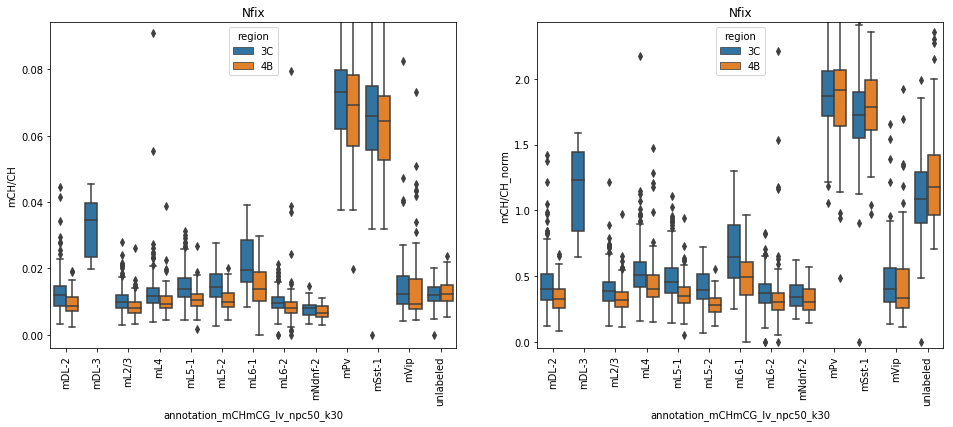

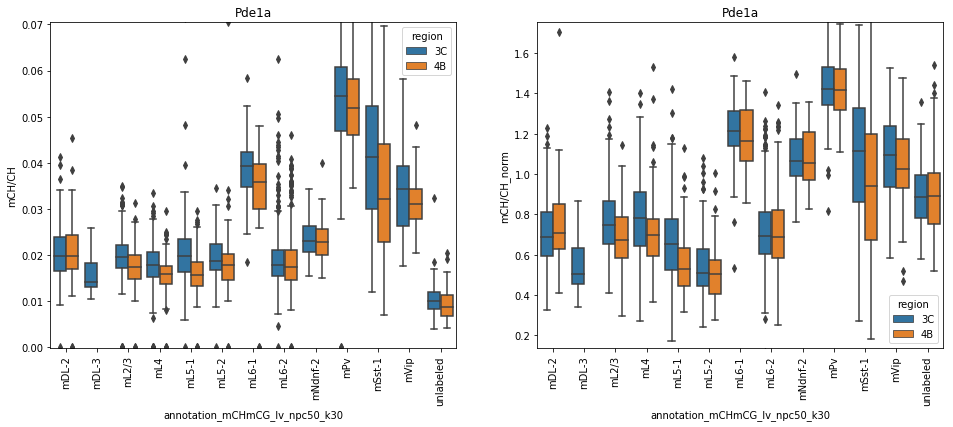

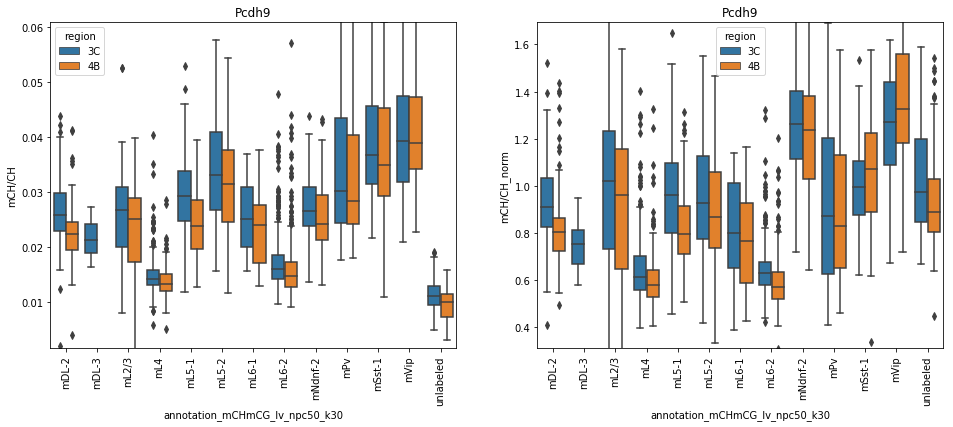

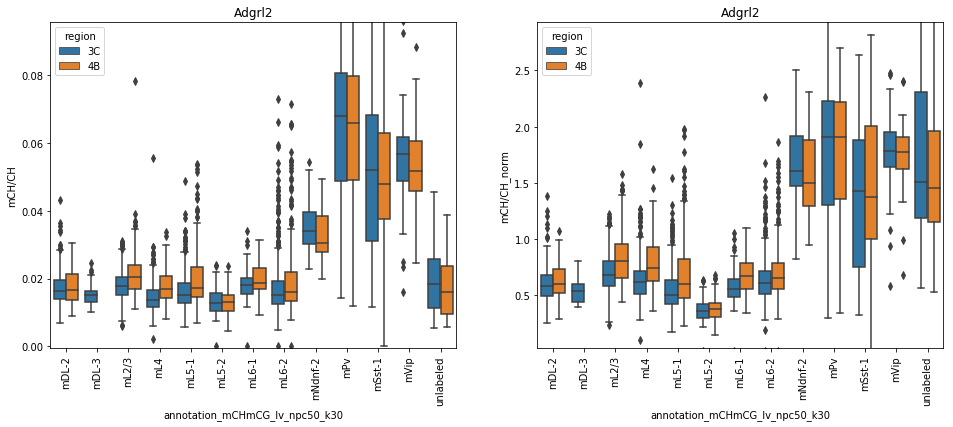

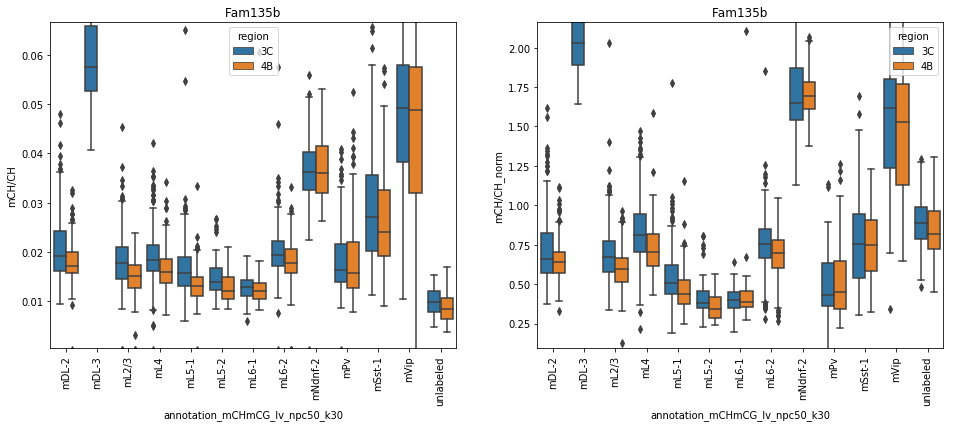

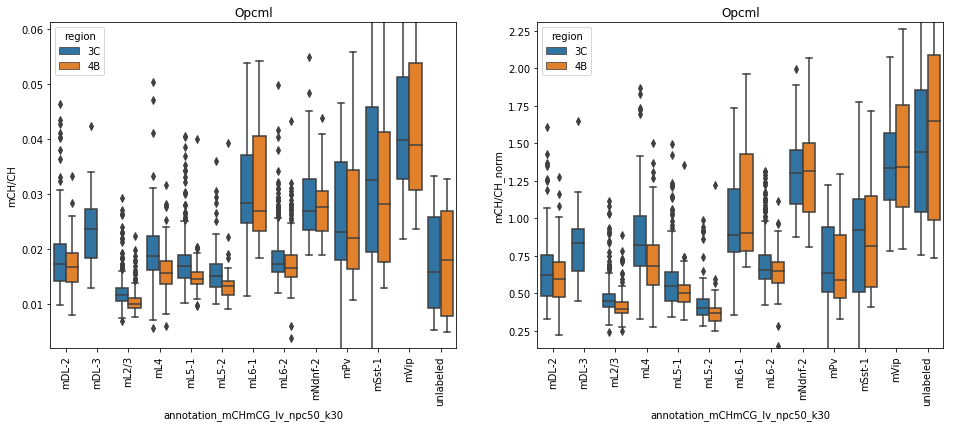

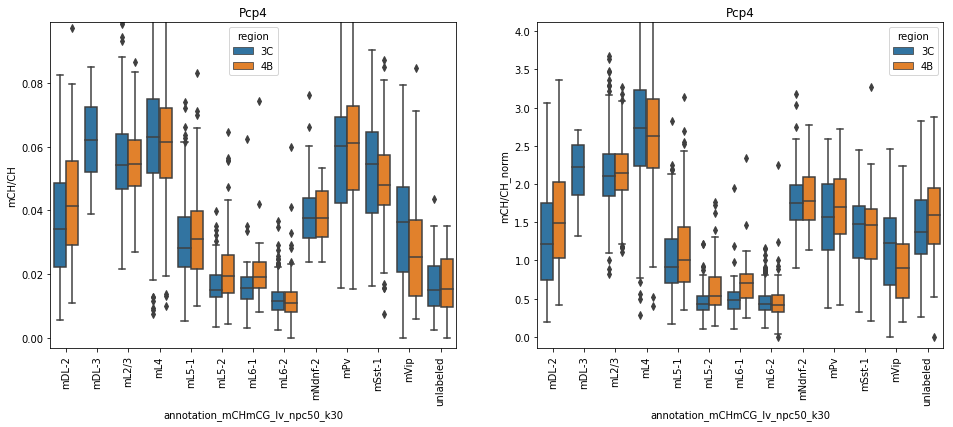

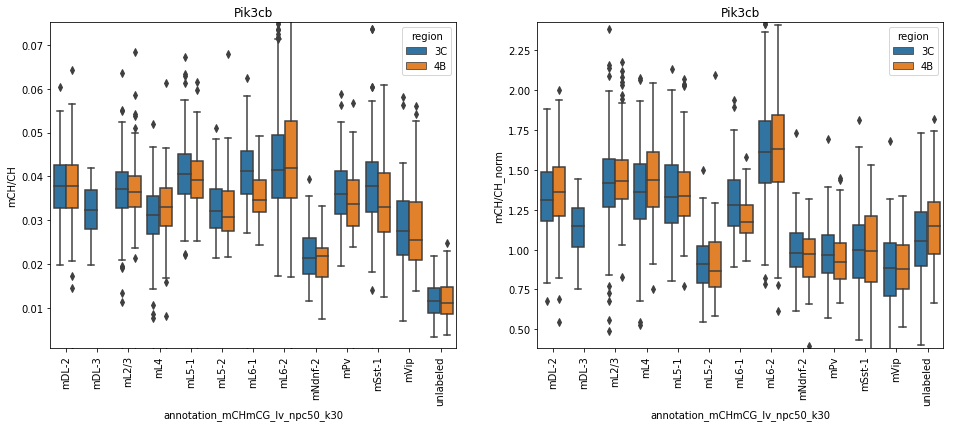

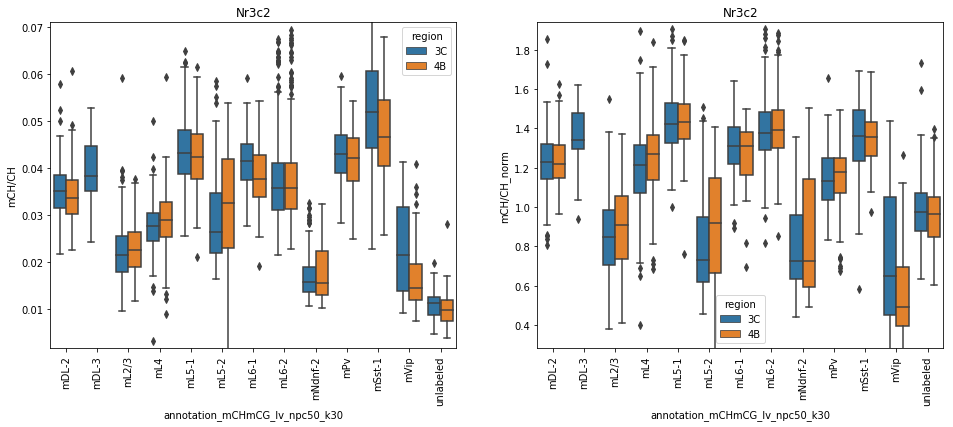

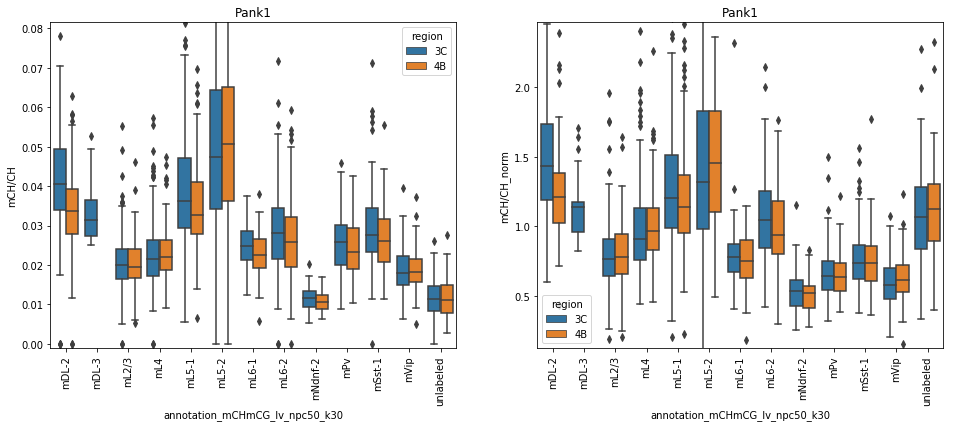

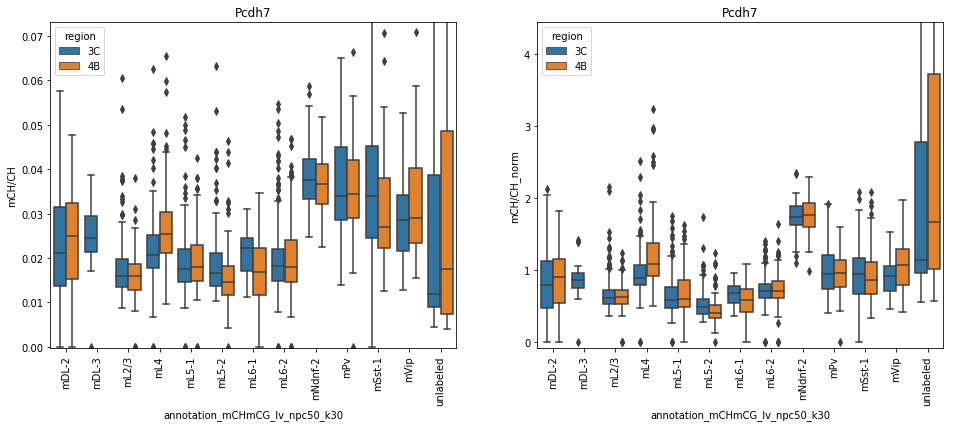

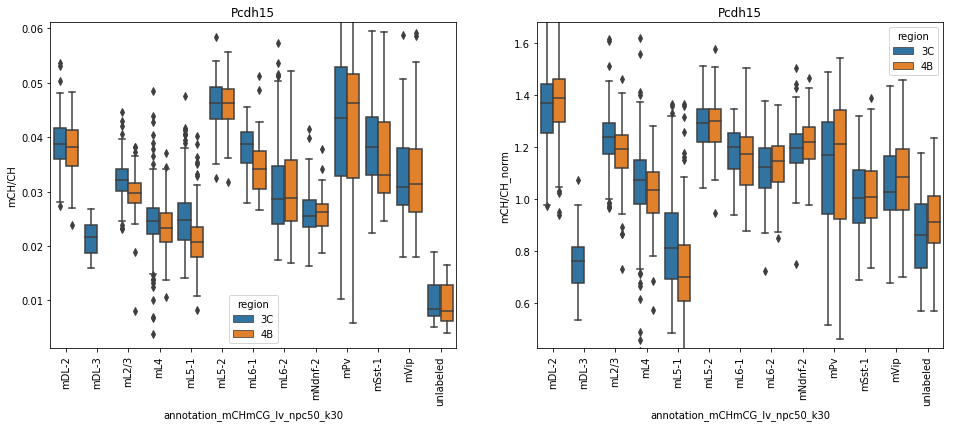

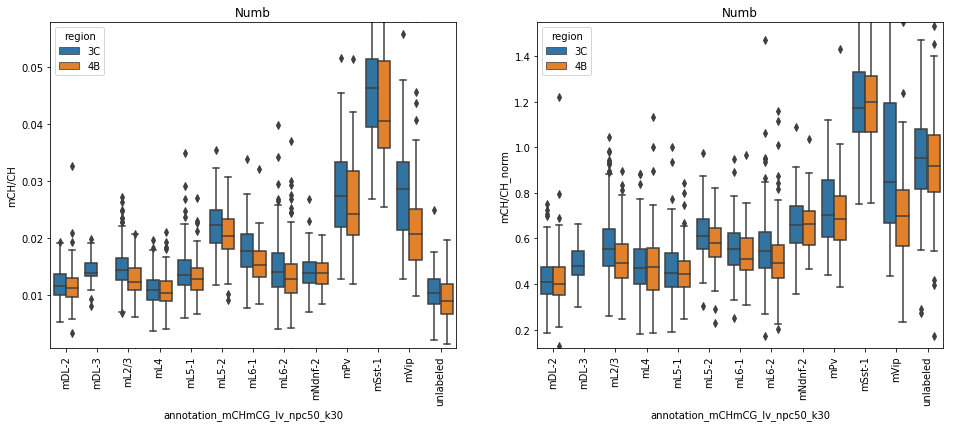

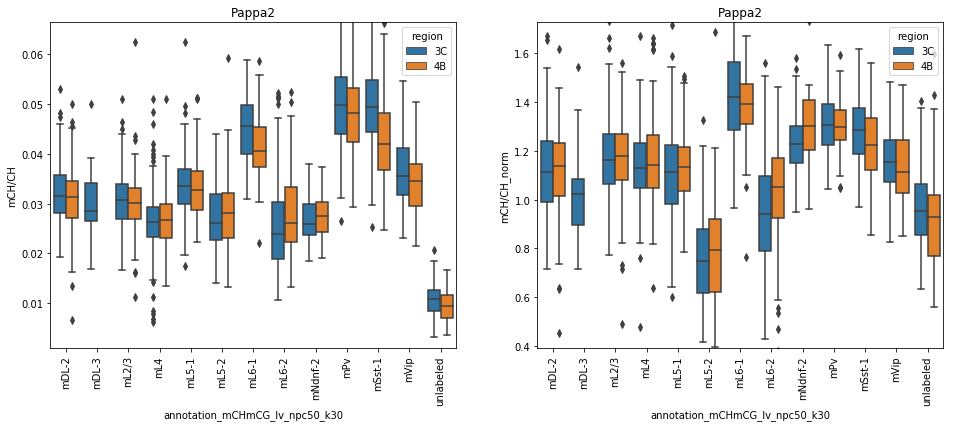

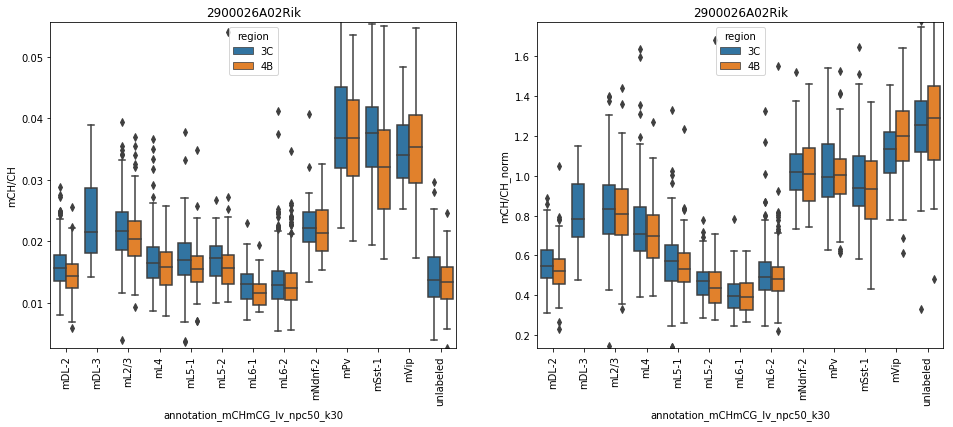

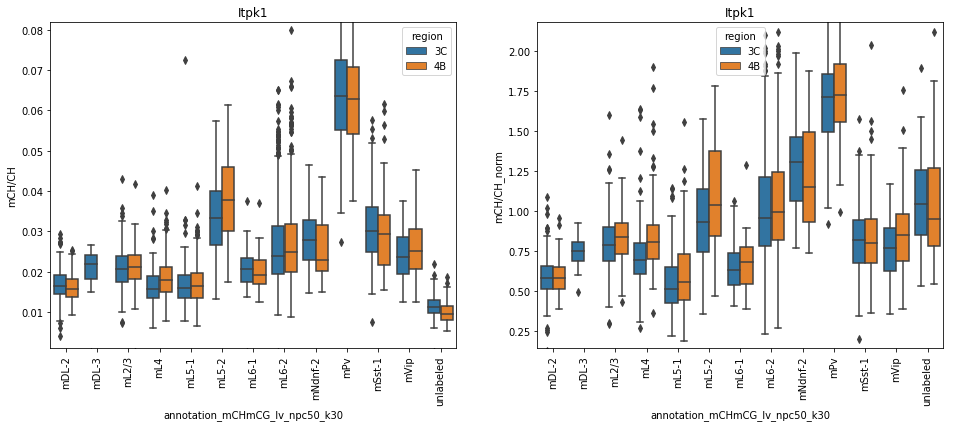

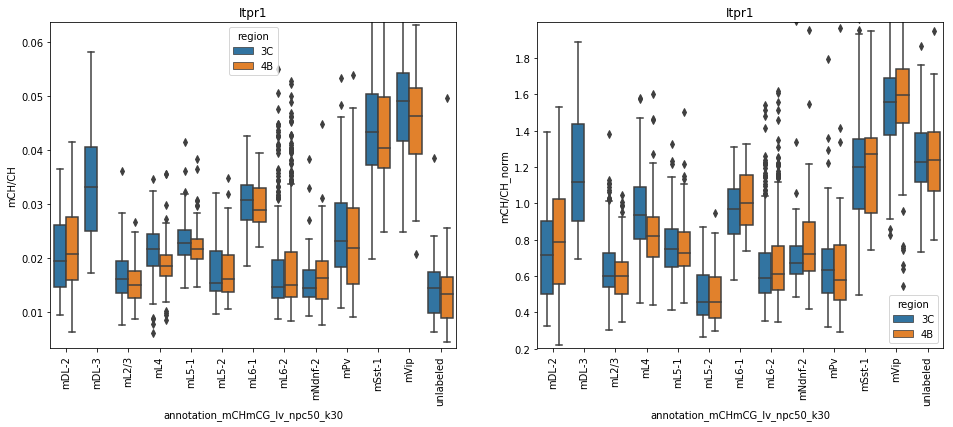

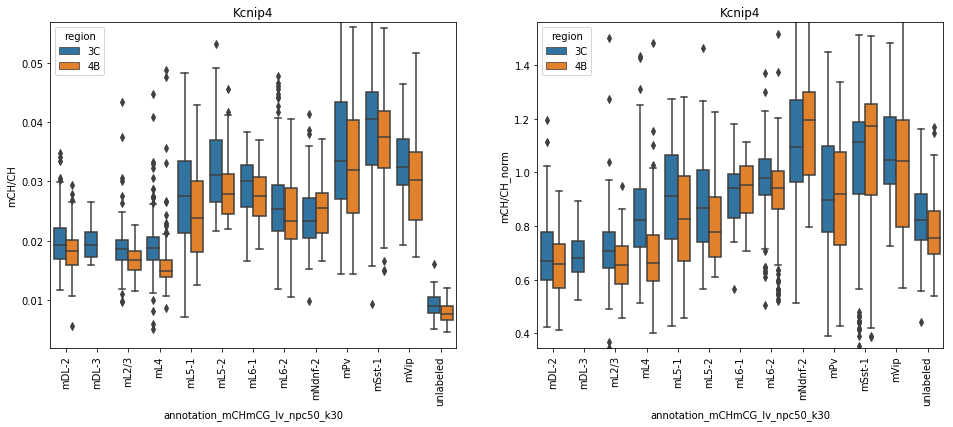

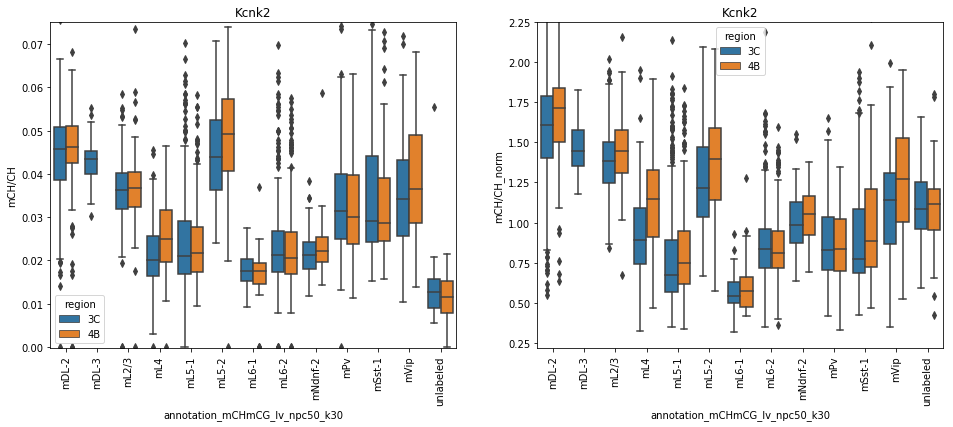

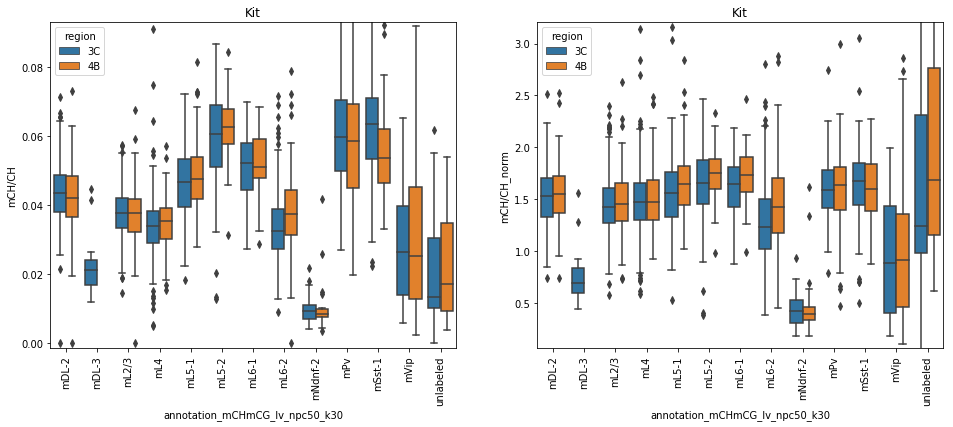

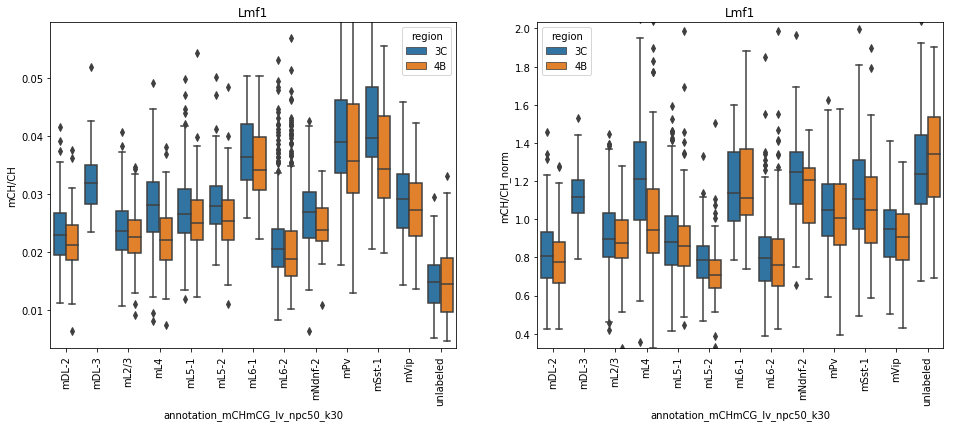

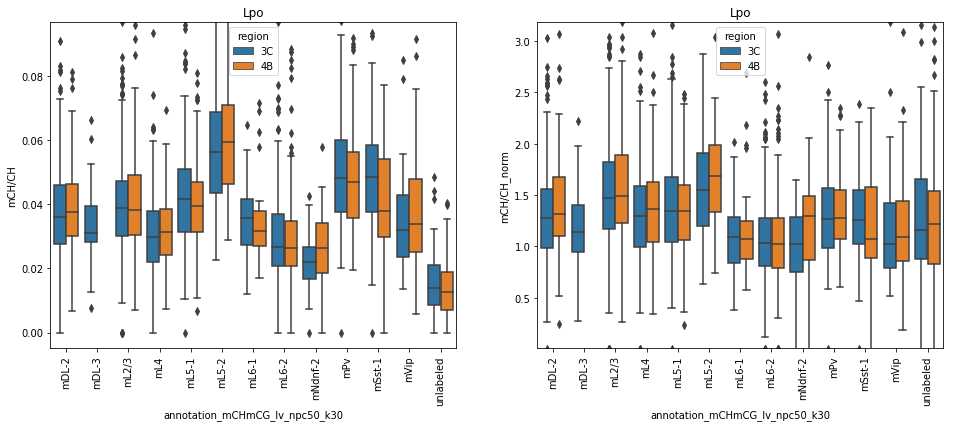

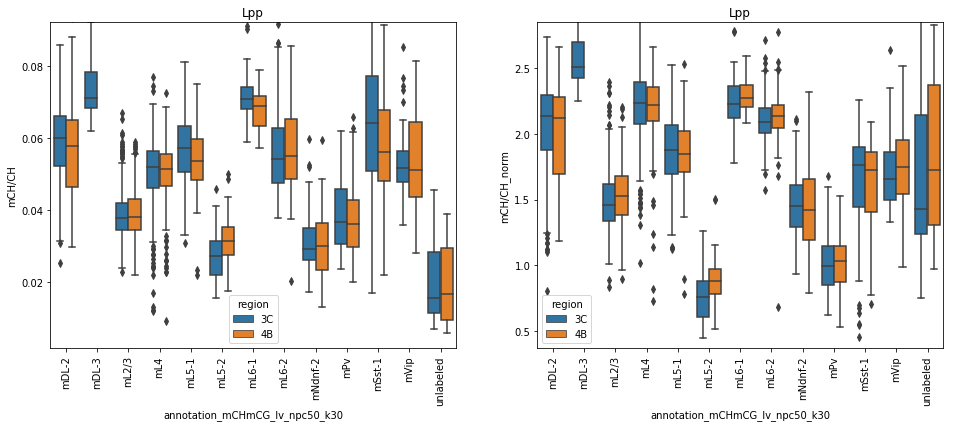

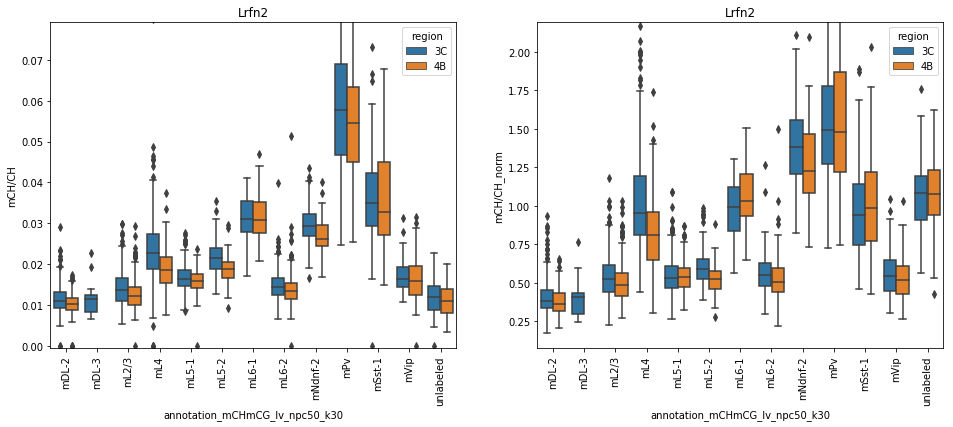

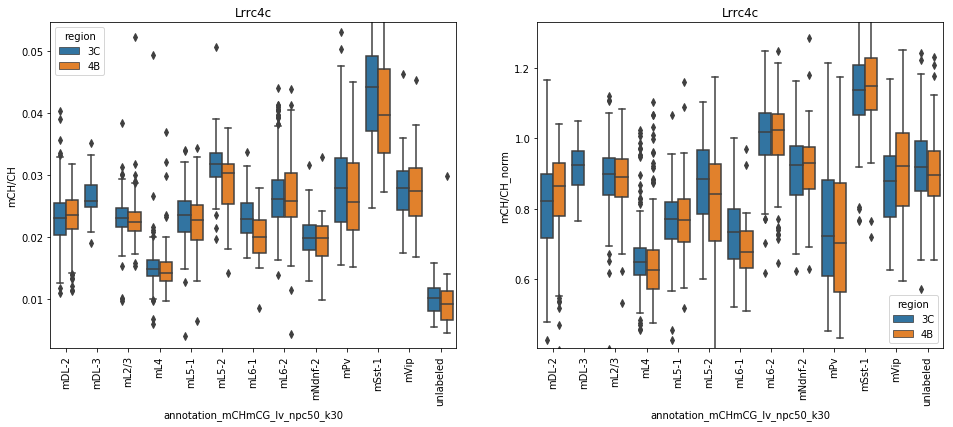

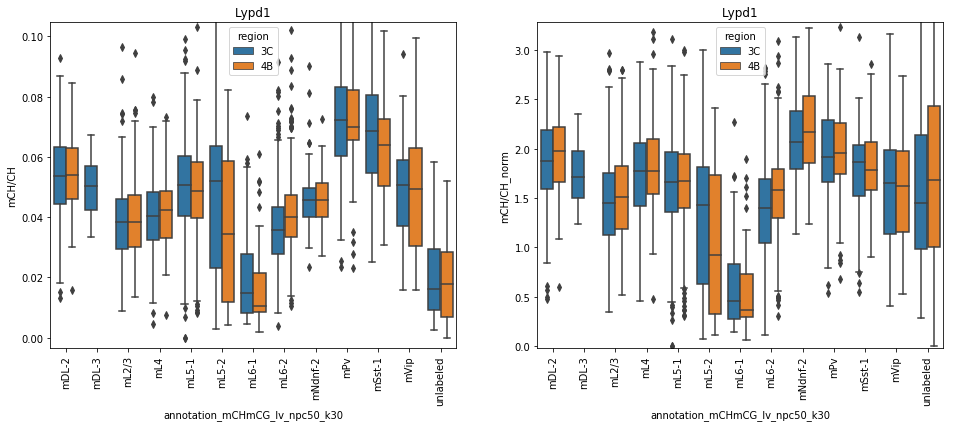

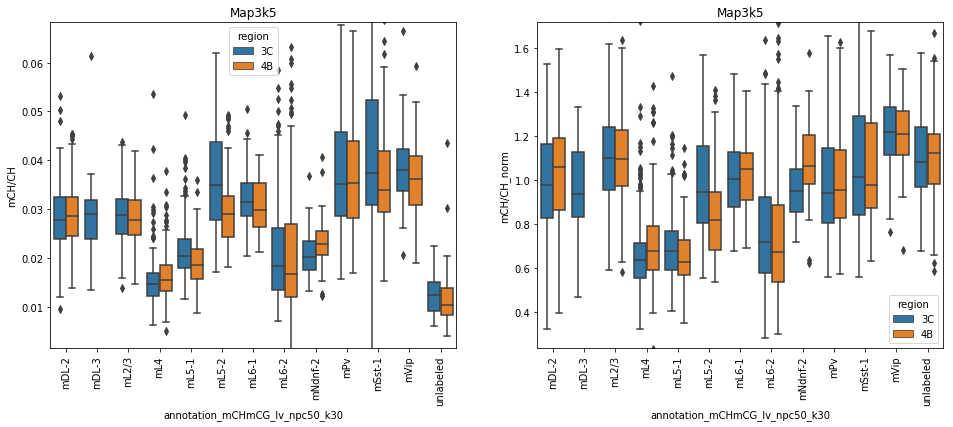

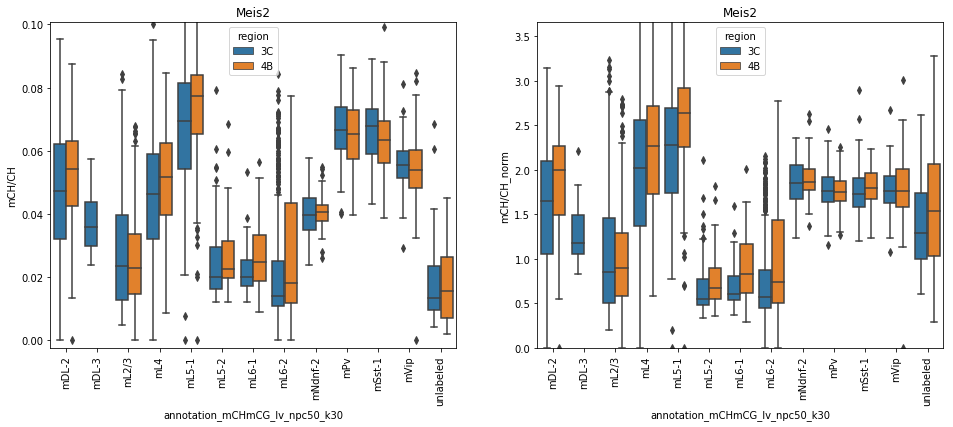

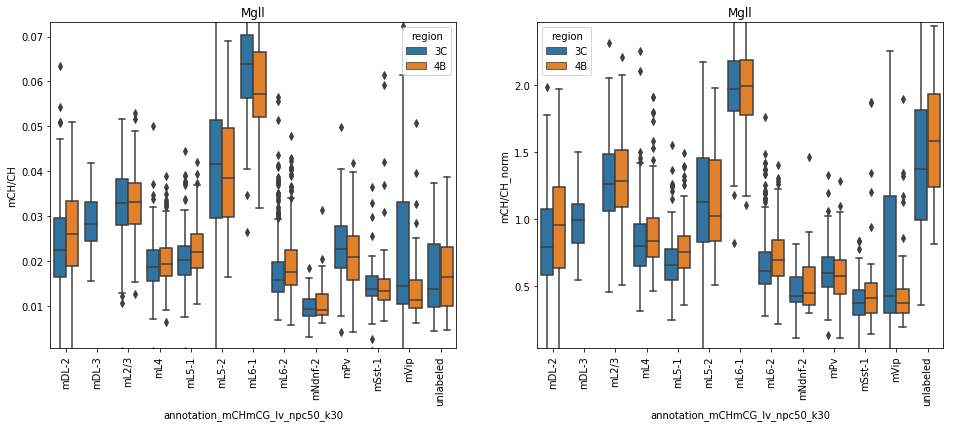

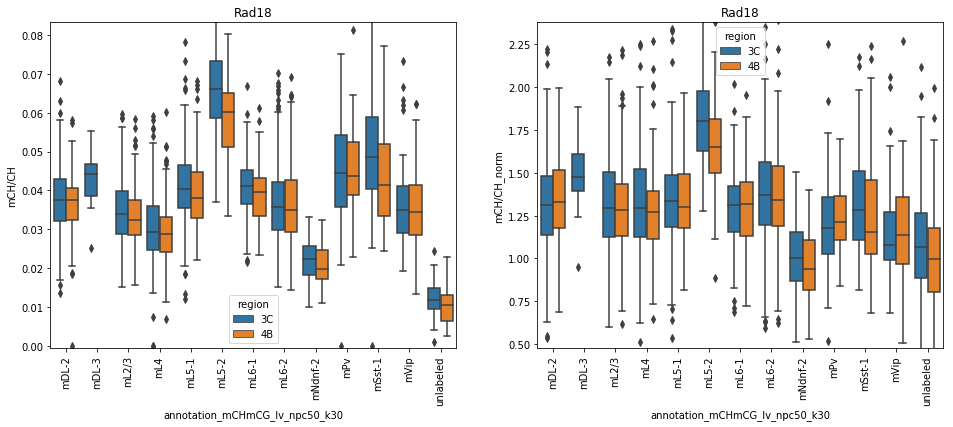

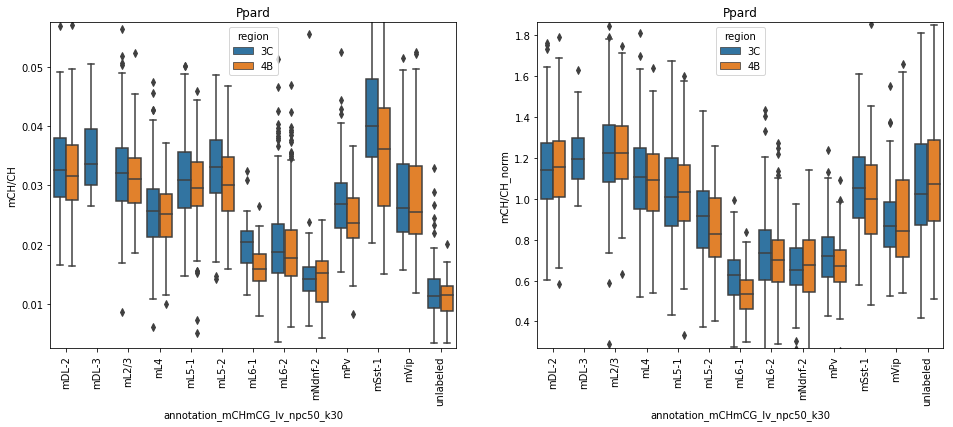

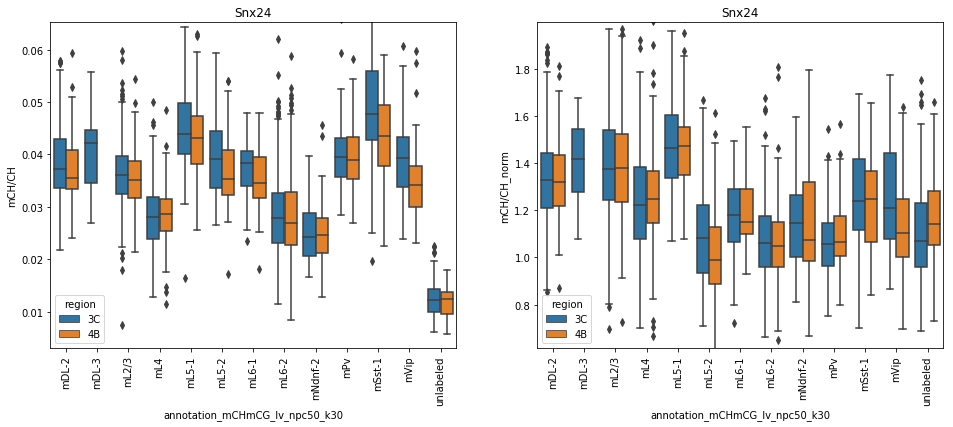

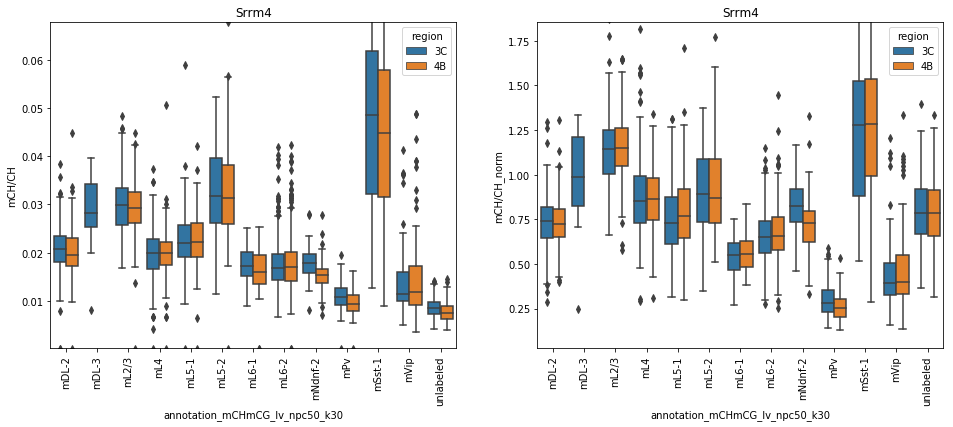

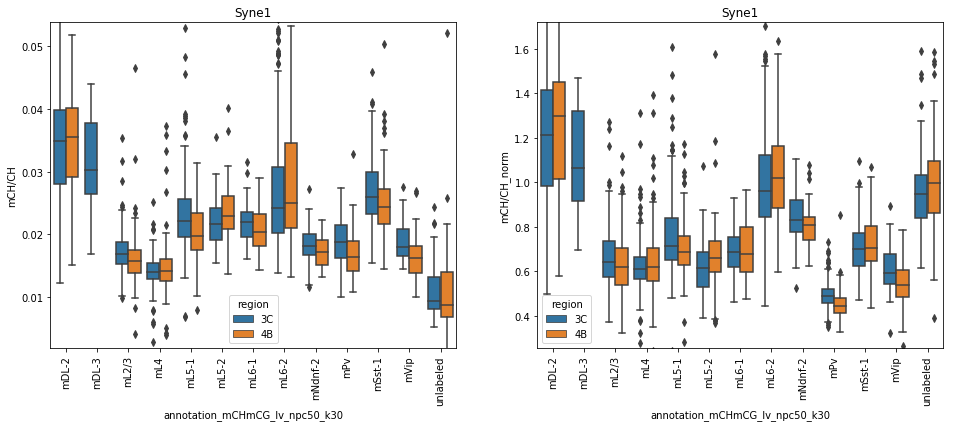

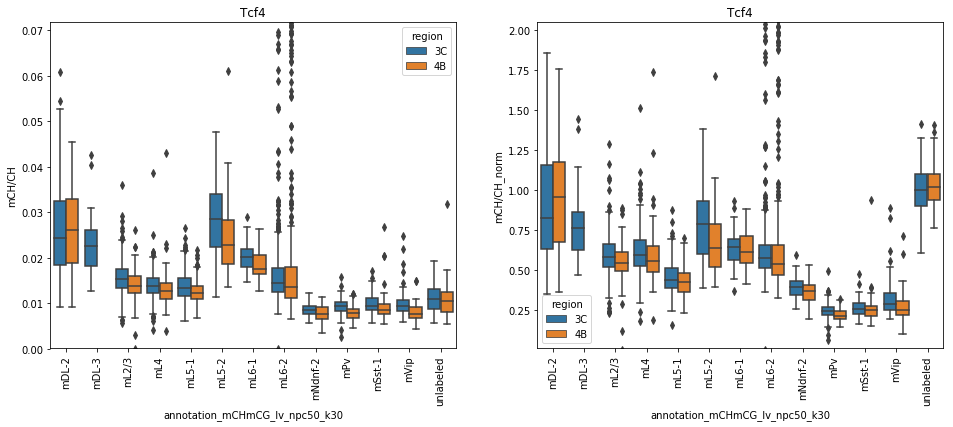

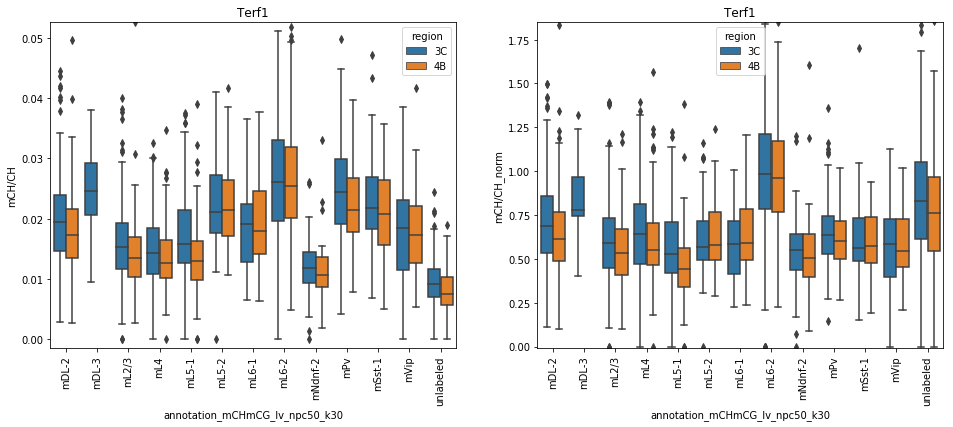

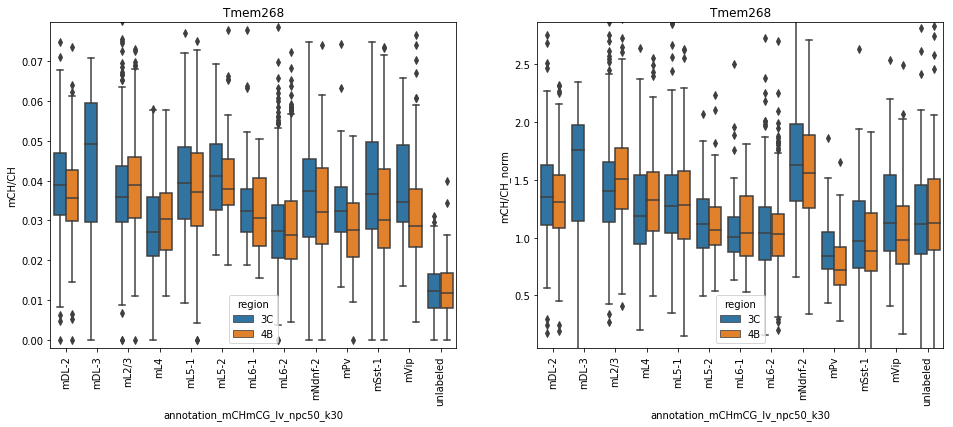

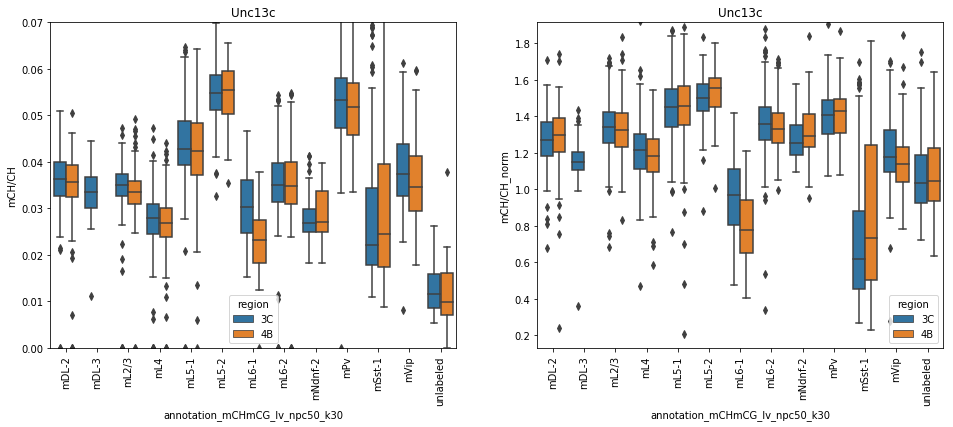

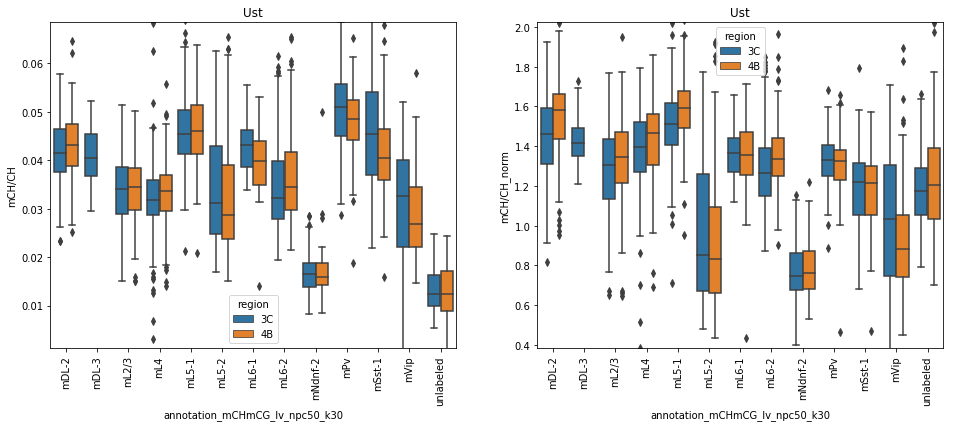

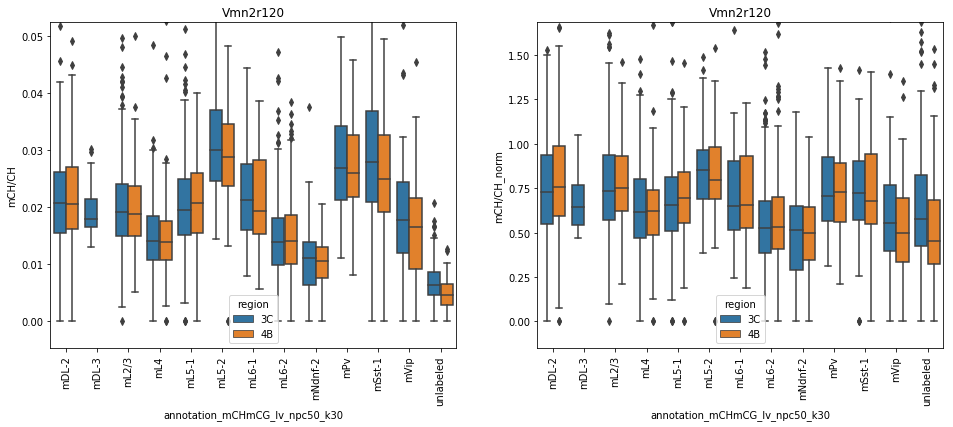

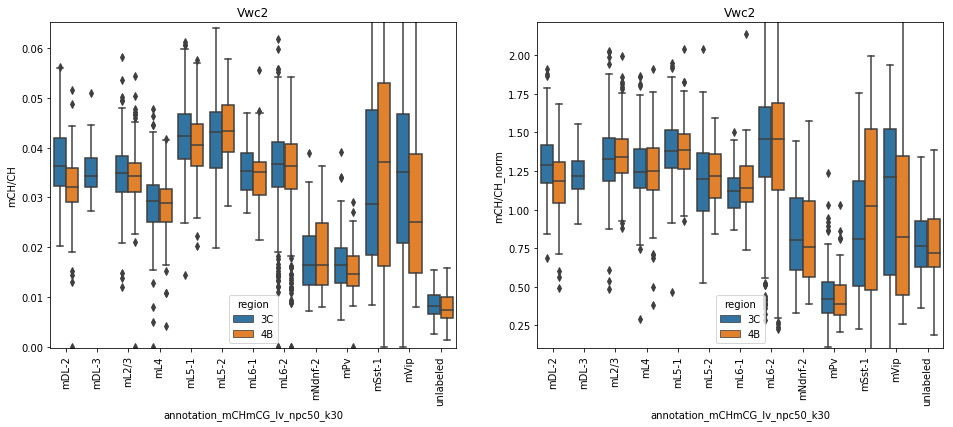

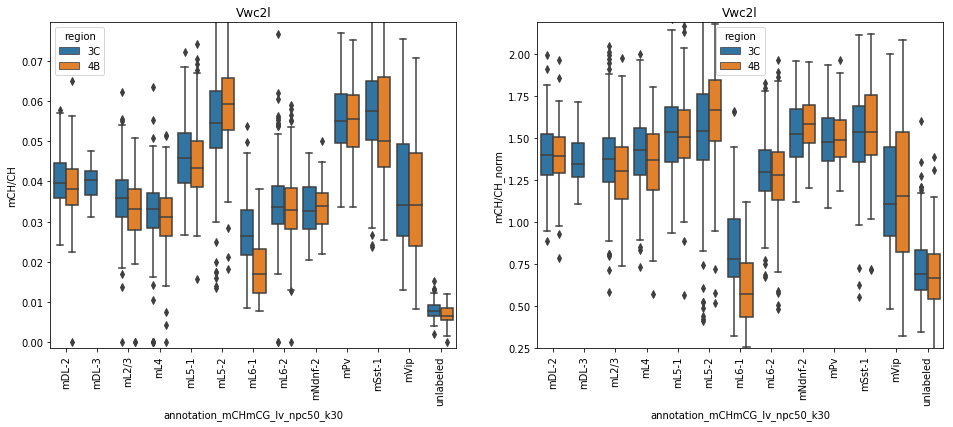

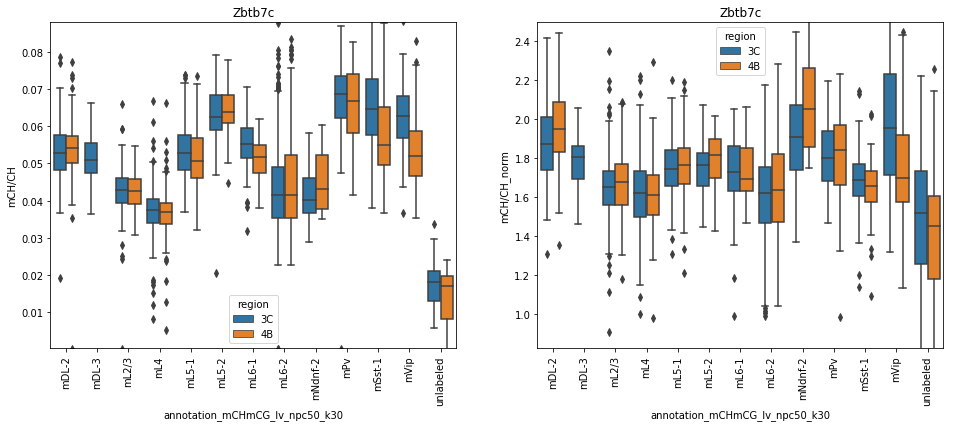

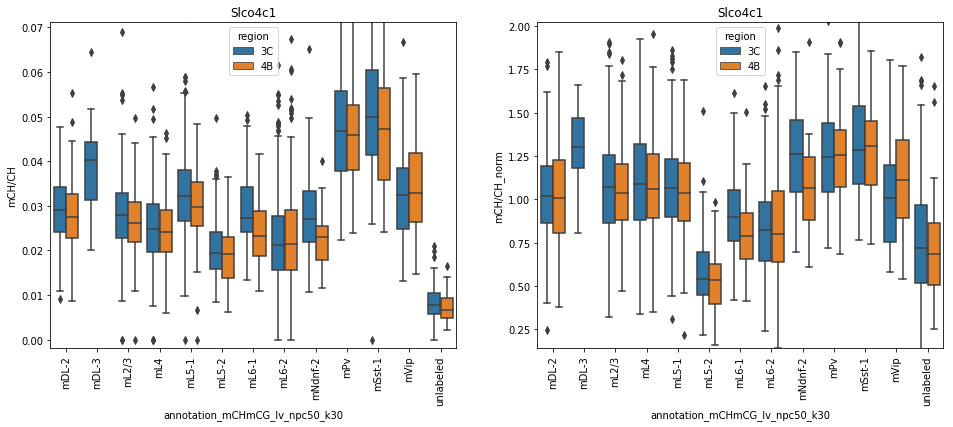

In [39]:
# Look at those genes in detail
# boxplot 3C vs 4B




for gene_name in top_genes_stats[top_genes_stats['mCH_range'] > 0.04].gene_name[:50]:
    gene_id = df_gene[df_gene.gene_name==gene_name].index.values[0]
    gene_table = id2table(gene_id)
    sql = """SELECT cell_name, mCH, CH, global_mCH, dataset, {}, {}
            FROM {} 
            JOIN cells 
            ON {}.cell_id = cells.cell_id
            JOIN {}
            ON {}.cell_id = cells.cell_id""".format(cluster_col, annot_col, gene_table, gene_table, ens, ens)
    dfg = pd.read_sql(sql, engine)
    dfg['mCH/CH'] = dfg.mCH/dfg.CH
    dfg['mCH/CH_norm'] = dfg['mCH/CH']/dfg['global_mCH']
    dfg['region'] = [dataset[len('CEMBA_'):-len('_171206')] for dataset in dfg['dataset']]
    dfg[annot_col] = dfg[annot_col].fillna('unlabeled')
    order = sorted(dfg[annot_col].unique().tolist())
    
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    ax = axs[0]
    sns.boxplot(x=annot_col, y='mCH/CH', hue='region', order=order, data=dfg, ax=ax)
    yrange = [np.nanpercentile(dfg['mCH/CH'].values, 1), np.nanpercentile(dfg['mCH/CH'].values, 99)]
    yrange[0] = yrange[0] - 0.1*(yrange[1] - yrange[0])
    yrange[1] = yrange[1] + 0.1*(yrange[1] - yrange[0])
    ax.set_ylim(yrange)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_title(gene_name)
    
    ax = axs[1]
    sns.boxplot(x=annot_col, y='mCH/CH_norm', hue='region', order=order, data=dfg, ax=ax)
    yrange = [np.nanpercentile(dfg['mCH/CH_norm'].values, 1), np.nanpercentile(dfg['mCH/CH_norm'].values, 99)]
    yrange[0] = yrange[0] - 0.1*(yrange[1] - yrange[0])
    yrange[1] = yrange[1] + 0.1*(yrange[1] - yrange[0])
    ax.set_ylim(yrange)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_title(gene_name)
    plt.show()
    
# tune visualization

In [40]:
# f1_macros of hDL-1, hL6-2 are due to skewed dataset (low MB_EA)
df_info.groupby(['cluster_annotation', 'Biosample'])['mCH/CH', 'mCG/CG'].count()

KeyError: "Columns not found: 'mCG/CG'"

# ICA marker genes (see if the lists converge)

1. run PCA, reduce dimensions of feature space (genes)

2. run ICA in PC spaces

3. identify certain interesting ICs
    - plot ICs against each other

    - plot IC on tSNE

4. Plot IC coefficients, look at top genes



In [ ]:

cell_types_tr2 = sr_n_tr.index.values
# for celltype in cell_types_tr2:
celltype = 'mL2/3'
df_xy0, df_xy1 = get_data(celltype)
df_x = df_xy1.filter(regex='^ENS')

df_x.head
print(df_x.shape)

In [ ]:
# ICA workflow

n_comp = 10
# fit PCA
pca = PCA(n_components=n_comp).fit(df_x)
pcs = pca.transform(df_x)

df_pc_axis = pd.DataFrame(pca.components_, 
                       index=['PC' + str(i+1) for i in range(n_comp)], 
                       columns=df_x.columns)

df_pc_axis.head()


In [ ]:
# visualize PCA
# np.cov(pcs.T)
# np.diag(np.cov(pcs.T).diagonal())



In [ ]:
# ICA after PCA and reconstruct data
# manual whitening
C = np.sqrt(np.diag(np.cov(pcs.T).diagonal()))
pcsw = np.dot(pcs, np.linalg.inv(C))
# check if whitened
# print(np.cov(pcsw.T))

# fit ICA
ica = FastICA(whiten=False).fit(pcsw)
ics = ica.transform(pcsw)
df_ics = pd.DataFrame(ics, columns=['IC'+str(i+1) for i in range(n_comp)], index=df_x.index)

axis = np.dot(np.dot(ica.components_, C), pca.components_)
df_ic_axis = pd.DataFrame(axis, 
                       index=['IC' + str(i+1) for i in range(n_comp)], 
                       columns=df_x.columns)

In [ ]:
# plot ICs

df_plot_ics = pd.merge(df_ics, df_info, left_index=True, right_index=True)
print(df_plot_ics.shape)

g = sns.pairplot(df_plot_ics[df_ics.columns.tolist() + ['Biosample']], hue='Biosample', 
                 diag_kind='kde', markers='o', size=2.5)
# print(g.axes.shape)
# for i, j in zip(*np.triu_indices_from(g.axes, k=1)):
#     g.axes[i, j].set_visible(False)
plt.show()

In [ ]:
# plot IC tsne
plot_tsne_values(df_plot_ics, tx=tsne_cols[0], ty=tsne_cols[1], tc='IC1')

In [ ]:
# 
# look at IC1 (which seperates MB_EA from other biosamples)

fig, axs = plt.subplots(1, 3, figsize=(12, 6))
icc = df_ic_axis.loc['IC1', :].apply(np.abs).sort_values(ascending=False)
ax = axs[0]
ax.plot(icc.values, 'o-')
ax = axs[1]
ax.plot(icc.values[:100], 'o-')
ax = axs[2]
ax.plot(icc.values[:10], 'o-')
fig.tight_layout()
plt.show()

In [ ]:
# what are those genes
n_top = 30
sr_top_genes_2 = df_gene.loc[icc.index.values[:n_top], 'geneName']
sr_top_genes_2.to_frame()

In [ ]:
# tsne_box plot

for gene_id, gene_name in sr_top_genes_2.iteritems():
    df_plot = pd.merge(df_info, df_xy[[gene_id]], left_index=True, right_index=True) 
    tsne_and_boxplot(df_plot, tc=gene_id, bx='Biosample', by=gene_id,
                    output=None, show=True, close=False, 
                    title=('Genebody mCH: %s' % gene_name), 
                    figsize=(6,8),
                    t_xlim=None, t_ylim=None, b_xlim=None, b_ylim=None, 
                    low_p=5, hi_p=95)

In [ ]:
# those that are in list 1 but not in 2 may be genes that separates bewteen MB_v1 and MB_EB

In [ ]:
# compare LDA with top ANOVA genes and LDA with random genes

In [ ]:
# find an index that show "exci v.s. inhi variance difference"

# eta-squared distribution for effect size

# if ANOVA for PV cells are skewed by few cells in MB_EB

In [ ]:
# run exactly the same analysis with mCG